In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier, LGBMRegressor
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### lightgbm

In [2]:
def LightGBMC(train_x, test_x, train_y, test_y, config):
    
    clf = LGBMClassifier(**config, class_weight = {0:1, 1:3})
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    define_predict = (predict_y > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result


def LightGBMR(train_x, test_x, train_y, test_y, config):
    
    reg = LGBMRegressor(**config)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def runall_LightGBMC(num_set, trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
        
        result = LightGBMC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
        
    return table_set
    
    
def runall_LightGBMR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = LightGBMR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### optuna

In [3]:
def LightGBM_creator(train_data, mode, num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        param = {
            'objective': trial.suggest_categorical('objective', ['binary', 'cross_entropy']),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300, step = 50),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step = 5),
            'min_child_samples': trial.suggest_int('min_child_samples', 3, 24, step = 3),
            'max_depth': trial.suggest_int('max_depth', 3, 15, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.425, step = 0.05),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 5), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 5) # lambda
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = LightGBMC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                aging = table['Aging Rate']
                effi = table['Efficiency']
                result_list.append(recall - 0.5*aging)

            elif mode == 'R':
                result = LightGBMR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

## 

### loading training & testing data

In [4]:
### training data ### 
training_month = range(1, 7)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 1:

Dimension of dataset 0 : (17735, 84)  balance ratio: 1181.0
Dimension of dataset 1 : (296, 84)  balance ratio: 1.0
Dimension of dataset 2 : (420, 84)  balance ratio: 1.0
Dimension of dataset 3 : (328, 84)  balance ratio: 1.0
Dimension of dataset 4 : (300, 84)  balance ratio: 1.0
Dimension of dataset 5 : (298, 84)  balance ratio: 1.0
Dimension of dataset 6 : (370, 84)  balance ratio: 1.0
Dimension of dataset 7 : (300, 84)  balance ratio: 1.0
Dimension of dataset 8 : (300, 84)  balance ratio: 1.0
Dimension of dataset 9 : (165, 84)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 2:

Dimension of dataset 0 : (39009, 90)  balance ratio: 533.0
Dimension of dataset 1 : (1460, 90)  balance ratio: 1.0
Dimension of dataset 2 : (1908, 90)  balance ratio: 1.0
Dimension of dataset 3 : (1604, 90)  balance ratio: 1.0
Dimension of dataset 4 : (1460, 90)  balance ratio: 1.0
Dimension of dataset 5 : (1465, 90)  balance ratio: 1.0
Dimension of dataset

### search for best hyperparameter

In [5]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m1m6_m7_3criteria_LightGBM',
                                     creator = LightGBM_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 16:58:06,512] A new study created in memory with name: no-name-a984c6ab-4116-48f7-b715-6115eb92cb42


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.11594202898550725 
Recall: 0.056338028169014086 
Aging Rate: 0.0011931317113658764
Precision: 0.15873015873015872 
Recall: 0.08264462809917356 
Aging Rate: 0.0010893811277688436
Precision: 0.04285714285714286 
Recall: 0.02654867256637168 
Aging Rate: 0.0012104234752987153
[I 2021-11-19 16:58:12,447] Trial 0 finished with value: 0.054594953559114194 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.08220167473517778, 'reg_lambda': 0.00470622388026486}. Best is trial 0 with value: 0.054594953559114194.
Precision: 0.925 
Recall: 0.3333333333333333 
Aging Rate: 0.0006916705573135516
Precision: 0.875 
Recall: 0.2517985611510791 
Aging Rate: 0.0006916705573135516
Precision: 0.7959183673469388 
Recall: 0.3170731707317073 
Aging Rate: 0.0008472964327091006
[I 2021-11-19 16:58:26,363] Trial 1 finished with value: 0.30036324881

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-19 16:58:36,318] Trial 2 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.10225996643708392, 'reg_lambda': 0.19002546228060258}. Best is trial 1 with value: 0.30036324881415055.
Precision: 0.3175355450236967 
Recall: 0.4527027027027027 
Aging Rate: 0.0036485621898289843
Precision: 0.2318840579710145 
Recall: 0.38095238095238093 
Aging Rate: 0.0035793951340976292
Precision: 0.29651162790697677 
Recall: 0.4322033898305085 
Aging Rate: 0.002974183396448272
[I 2021-11-19 16:58:46,010] Trial 3 finished with value: 0.4202524677084682 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.0014486237079884036, 'reg_

Precision: 0.47794117647058826 
Recall: 0.5462184873949579 
Aging Rate: 0.002351679894866075
Precision: 0.782608695652174 
Recall: 0.7758620689655172 
Aging Rate: 0.0019885528522764605
Precision: 0.5654761904761905 
Recall: 0.7037037037037037 
Aging Rate: 0.0029050163407169163
[I 2021-11-19 17:02:08,234] Trial 15 finished with value: 0.6740538785067498 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.6889486278060851, 'reg_lambda': 0.2000166750834321}. Best is trial 15 with value: 0.6740538785067498.
Precision: 0.6869565217391305 
Recall: 0.5808823529411765 
Aging Rate: 0.0019885528522764605
Precision: 0.5669291338582677 
Recall: 0.6101694915254238 
Aging Rate: 0.002196054019470526
Precision: 0.7047619047619048 
Recall: 0.6166666666666667 
Aging Rate: 0.001815635212948073
[I 2021-11-19 17:02:25,032] Trial 16 finished with

Precision: 0.5 
Recall: 0.13675213675213677 
Aging Rate: 0.0005533364458508412
[I 2021-11-19 17:05:16,819] Trial 27 finished with value: 0.10813547157696235 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.00043391887675739096, 'reg_lambda': 0.04595114832771848}. Best is trial 22 with value: 0.7680447396152007.
Precision: 0.9454545454545454 
Recall: 0.7938931297709924 
Aging Rate: 0.0019020940326122668
Precision: 0.9468085106382979 
Recall: 0.7355371900826446 
Aging Rate: 0.0016254258096868462
Precision: 0.9010989010989011 
Recall: 0.7130434782608696 
Aging Rate: 0.0015735505178883298
[I 2021-11-19 17:05:30,410] Trial 28 finished with value: 0.7466410876448043 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 

Precision: 0.9072164948453608 
Recall: 0.8 
Aging Rate: 0.0016773011014853626
Precision: 0.8285714285714286 
Recall: 0.7767857142857143 
Aging Rate: 0.001815635212948073
Precision: 0.8392857142857143 
Recall: 0.734375 
Aging Rate: 0.0019366775604779444
[I 2021-11-19 17:09:29,974] Trial 40 finished with value: 0.7694819691160862 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.002417397286824473, 'reg_lambda': 1.4181665852403318}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.018229166666666668 
Recall: 0.059322033898305086 
Aging Rate: 0.006640037350210095
Precision: 0.010676156583629894 
Recall: 0.02631578947368421 
Aging Rate: 0.0048589856651277
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0007608376130449067
[I 2021-11-19 17:09:52,041] Trial 41 finished with value: 0.02650263101926598 and parameters: {'objective

Precision: 0.8504672897196262 
Recall: 0.728 
Aging Rate: 0.0018502187408137504
Precision: 0.8804347826086957 
Recall: 0.801980198019802 
Aging Rate: 0.0015908422818211685
[I 2021-11-19 17:13:32,425] Trial 52 finished with value: 0.7764417003915017 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.00014289127253563482, 'reg_lambda': 3.1040015401007213}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.018633540372670808 
Recall: 0.09523809523809523 
Aging Rate: 0.01113589597274818
Precision: 0.020703933747412008 
Recall: 0.08196721311475409 
Aging Rate: 0.008351921979561135
Precision: 0.0043859649122807015 
Recall: 0.026785714285714284 
Aging Rate: 0.011827566530061732
[I 2021-11-19 17:13:58,247] Trial 53 finished with value: 0.06277777679912604 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estim

Precision: 0.8448275862068966 
Recall: 0.784 
Aging Rate: 0.0020058446162092994
[I 2021-11-19 17:17:07,061] Trial 64 finished with value: 0.7636086108401888 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.03933533342556992, 'reg_lambda': 0.11436151102917909}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.8677685950413223 
Recall: 0.7835820895522388 
Aging Rate: 0.0020923034358734933
Precision: 0.8529411764705882 
Recall: 0.7372881355932204 
Aging Rate: 0.0017637599211495565
Precision: 0.7708333333333334 
Recall: 0.6788990825688074 
Aging Rate: 0.0016600093375525237
[I 2021-11-19 17:17:22,738] Trial 65 finished with value: 0.7323370904556596 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 9, 'learning_rat

Precision: 0.45161290322580644 
Recall: 0.784 
Aging Rate: 0.003752312773426017
Precision: 0.21875 
Recall: 0.5121951219512195 
Aging Rate: 0.004980028012657571
Precision: 0.36363636363636365 
Recall: 0.7218045112781954 
Aging Rate: 0.00456502567826944
[I 2021-11-19 17:21:07,899] Trial 77 finished with value: 0.6704503166657462 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0009101508568610982, 'reg_lambda': 0.06133853422050127}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.8490566037735849 
Recall: 0.7894736842105263 
Aging Rate: 0.0018329269768809116
Precision: 0.8552631578947368 
Recall: 0.7386363636363636 
Aging Rate: 0.0013141740588957479
Precision: 0.8888888888888888 
Recall: 0.7154471544715447 
Aging Rate: 0.0017118846293510401
[I 2021-11-19 17:21:27,678] Trial 78 finished with value: 0.74

Precision: 0.9222222222222223 
Recall: 0.7477477477477478 
Aging Rate: 0.001556258753955491
Precision: 0.8910891089108911 
Recall: 0.7758620689655172 
Aging Rate: 0.0017464681572167177
[I 2021-11-19 17:25:01,881] Trial 89 finished with value: 0.7630009610699928 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0001061360096705619, 'reg_lambda': 2.706306031971328}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.004 
Recall: 0.008547008547008548 
Aging Rate: 0.004322940983209698
Precision: 0.02601156069364162 
Recall: 0.07627118644067797 
Aging Rate: 0.005982950320762221
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009804430149919593
[I 2021-11-19 17:25:16,603] Trial 90 finished with value: 0.024921011420246924 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample

Precision: 0.9166666666666666 
Recall: 0.8319327731092437 
Aging Rate: 0.001867510504746589
[I 2021-11-19 17:29:15,453] Trial 101 finished with value: 0.8063649278553334 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0001926474682214071, 'reg_lambda': 0.7362624710602048}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.8333333333333334 
Recall: 0.6779661016949152 
Aging Rate: 0.0016600093375525237
Precision: 0.9361702127659575 
Recall: 0.6423357664233577 
Aging Rate: 0.0016254258096868462
Precision: 0.8823529411764706 
Recall: 0.7142857142857143 
Aging Rate: 0.001469799934291297
[I 2021-11-19 17:29:33,504] Trial 102 finished with value: 0.6774033216210741 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 6, 'max_dep

Precision: 0.8 
Recall: 0.8347826086956521 
Aging Rate: 0.0020750116719406545
Precision: 0.8778625954198473 
Recall: 0.8518518518518519 
Aging Rate: 0.002265221075201881
Precision: 0.897196261682243 
Recall: 0.8275862068965517 
Aging Rate: 0.0018502187408137504
[I 2021-11-19 17:33:49,507] Trial 114 finished with value: 0.8370418139000257 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.000413154421181873, 'reg_lambda': 0.19812604492775188}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.5440414507772021 
Recall: 0.7664233576642335 
Aging Rate: 0.0033373104390378864
Precision: 0.41203703703703703 
Recall: 0.7946428571428571 
Aging Rate: 0.003735021009493178
Precision: 0.5612903225806452 
Recall: 0.7631578947368421 
Aging Rate: 0.0026802234095900123
[I 2021-11-19 17:34:04,761] Trial 115 finished with value: 0.7731159

Precision: 0.8936170212765957 
Recall: 0.7241379310344828 
Aging Rate: 0.0016254258096868462
Precision: 0.8653846153846154 
Recall: 0.703125 
Aging Rate: 0.001798343449015234
[I 2021-11-19 17:38:09,828] Trial 126 finished with value: 0.6971580557408954 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.004705214600304703, 'reg_lambda': 2.550033338231347}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.5503875968992248 
Recall: 0.5378787878787878 
Aging Rate: 0.002230637547336204
Precision: 0.6742424242424242 
Recall: 0.6846153846153846 
Aging Rate: 0.00228251283913472
Precision: 0.5102040816326531 
Recall: 0.5681818181818182 
Aging Rate: 0.002541889298127302
[I 2021-11-19 17:38:25,868] Trial 127 finished with value: 0.5957161569445639 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimato

Precision: 0.6850393700787402 
Recall: 0.7767857142857143 
Aging Rate: 0.002196054019470526
Precision: 0.732824427480916 
Recall: 0.7868852459016393 
Aging Rate: 0.002265221075201881
Precision: 0.7258064516129032 
Recall: 0.7894736842105263 
Aging Rate: 0.00214417872767201
[I 2021-11-19 17:42:14,233] Trial 139 finished with value: 0.783280639162236 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.00013454064842384207, 'reg_lambda': 0.11482355596981654}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.8260869565217391 
Recall: 0.7364341085271318 
Aging Rate: 0.0019885528522764605
Precision: 0.8512396694214877 
Recall: 0.865546218487395 
Aging Rate: 0.0020923034358734933
Precision: 0.9029126213592233 
Recall: 0.7622950819672131 
Aging Rate: 0.0017810516850823952
[I 2021-11-19 17:42:30,355] Trial 140 finished with valu

Precision: 0.8717948717948718 
Recall: 0.796875 
Aging Rate: 0.0020231363801421383
Precision: 0.7383177570093458 
Recall: 0.7821782178217822 
Aging Rate: 0.0018502187408137504
[I 2021-11-19 17:46:04,777] Trial 151 finished with value: 0.7914858284391869 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.003827998840827831, 'reg_lambda': 0.14036877053231103}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.8365384615384616 
Recall: 0.725 
Aging Rate: 0.001798343449015234
Precision: 0.7445255474452555 
Recall: 0.7786259541984732 
Aging Rate: 0.002368971658798914
Precision: 0.6644736842105263 
Recall: 0.753731343283582 
Aging Rate: 0.0026283481177914957
[I 2021-11-19 17:46:29,411] Trial 152 finished with value: 0.7513198219564176 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_es

Precision: 0.79 
Recall: 0.632 
Aging Rate: 0.0017291763932838788
[I 2021-11-19 17:49:55,342] Trial 163 finished with value: 0.6170380233456897 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00014128784058445765, 'reg_lambda': 0.5700972869178966}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.3112244897959184 
Recall: 0.5041322314049587 
Aging Rate: 0.0033891857308364025
Precision: 0.4943181818181818 
Recall: 0.696 
Aging Rate: 0.003043350452179627
Precision: 0.2561576354679803 
Recall: 0.48148148148148145 
Aging Rate: 0.003510228078366274
[I 2021-11-19 17:50:08,896] Trial 164 finished with value: 0.558880776918583 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.3750

Precision: 0.3117408906882591 
Recall: 0.7 
Aging Rate: 0.004271065691411181
Precision: 0.07629427792915532 
Recall: 0.25225225225225223 
Aging Rate: 0.006346077363351836
Precision: 0.11538461538461539 
Recall: 0.3391304347826087 
Aging Rate: 0.00584461620929951
[I 2021-11-19 17:54:18,573] Trial 176 finished with value: 0.42771726913427655 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.00012444194841257117, 'reg_lambda': 0.07602953854497882}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.02857142857142857 
Recall: 0.06293706293706294 
Aging Rate: 0.005446905638844218
Precision: 0.038461538461538464 
Recall: 0.06474820143884892 
Aging Rate: 0.004046272760284277
Precision: 0.04777070063694268 
Recall: 0.13513513513513514 
Aging Rate: 0.00542961387491138
[I 2021-11-19 17:54:32,872] Trial 177 finished with value: 0.085119

Precision: 0.9 
Recall: 0.8114754098360656 
Aging Rate: 0.0019020940326122668
Precision: 0.9243697478991597 
Recall: 0.7913669064748201 
Aging Rate: 0.002057719908007816
Precision: 0.8490566037735849 
Recall: 0.8035714285714286 
Aging Rate: 0.0018329269768809116
[I 2021-11-19 17:57:52,617] Trial 188 finished with value: 0.801172458141188 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00011164055676177054, 'reg_lambda': 0.5030592325204204}. Best is trial 34 with value: 0.8450575399455756.
Precision: 0.5704225352112676 
Recall: 0.6090225563909775 
Aging Rate: 0.002455430478463108
Precision: 0.704 
Recall: 0.6717557251908397 
Aging Rate: 0.002161470491604849
Precision: 0.712 
Recall: 0.6691729323308271 
Aging Rate: 0.002161470491604849
[I 2021-11-19 17:58:06,347] Trial 189 finished with value: 0.648854009393936 and 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 18:00:42,742] A new study created in memory with name: no-name-ce378f00-6d43-47b4-b597-de643fcf56be


Precision: 0.8854166666666666 
Recall: 0.7142857142857143 
Aging Rate: 0.0016600093375525237
[I 2021-11-19 18:00:42,601] Trial 199 finished with value: 0.6952569872577842 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0016465533070716513, 'reg_lambda': 4.904806501053759}. Best is trial 34 with value: 0.8450575399455756.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.980115990057995 
Recall: 0.9974704890387859 
Aging Rate: 0.5056556346878928
Precision: 0.9842192691029901 
Recall: 0.9908026755852842 
Aging Rate: 0.5043988269794721
Precision: 0.9823380992430614 
Recall: 0.9948892674616695 
Aging Rate: 0.49811478843736906
[I 2021-11-19 18:00:47,587] Trial 0 finished with value: 0.743025935677791 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 2.0701146111183446, 'reg_lambda': 1.599982835993918}. Best is trial 0 with value: 0.743025935677791.
Precision: 0.9735576923076923 
Recall: 0.9975369458128078 
Aging Rate: 0.5228320067029745
Precision: 0.9735318444995864 
Recall: 0.9940878378378378 
Aging Rate: 0.5064935064935064
Precision: 0.9830645161290322 
Recall: 0.9910569105691057 
Aging Rate: 0.5194805194805194
[I 2021-11-19 18:00:50,414] Trial 1 finished with value: 0.7360928926270839 and para

Precision: 0.9827868852459016 
Recall: 0.9933719966859983 
Aging Rate: 0.5111018014243821
[I 2021-11-19 18:01:24,123] Trial 12 finished with value: 0.7404017011516583 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 2.0439882732829187, 'reg_lambda': 0.00012108539681075924}. Best is trial 8 with value: 0.744687396601995.
Precision: 0.9551752241238793 
Recall: 0.9949066213921901 
Aging Rate: 0.5140343527440302
Precision: 0.963884430176565 
Recall: 0.9950289975144988 
Aging Rate: 0.5219941348973607
Precision: 0.9582329317269076 
Recall: 0.9949958298582152 
Aging Rate: 0.5215751989945538
[I 2021-11-19 18:01:27,324] Trial 13 finished with value: 0.7353765351489772 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning

Precision: 0.996742671009772 
Recall: 0.9951219512195122 
Aging Rate: 0.514453288646837
Precision: 0.9906063193851409 
Recall: 0.9889173060528559 
Aging Rate: 0.4905739421868454
Precision: 0.9873843566021867 
Recall: 0.9957591178965225 
Aging Rate: 0.49811478843736906
[I 2021-11-19 18:02:15,433] Trial 25 finished with value: 0.7427424551777883 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0002669402366986881, 'reg_lambda': 0.01755316392250756}. Best is trial 21 with value: 0.7463842679278323.
Precision: 0.9932375316990701 
Recall: 0.9923986486486487 
Aging Rate: 0.49560117302052786
Precision: 0.9907251264755481 
Recall: 0.9882253994953742 
Aging Rate: 0.4968579807289485
Precision: 0.9904430929626412 
Recall: 0.9930313588850174 
Aging Rate: 0.482195224130708
[I 2021-11-19 18:02:21,118] Trial 26 finished with val

Precision: 0.9915611814345991 
Recall: 0.9957627118644068 
Aging Rate: 0.4964390448261416
[I 2021-11-19 18:03:15,465] Trial 37 finished with value: 0.7445496382887405 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0006344192836948326, 'reg_lambda': 0.0007475175708644819}. Best is trial 28 with value: 0.7474708232560761.
Precision: 0.9942004971002486 
Recall: 0.9884678747940692 
Aging Rate: 0.5056556346878928
Precision: 0.9898562975486053 
Recall: 0.9949022939677146 
Aging Rate: 0.49560117302052786
Precision: 0.9933333333333333 
Recall: 0.9892116182572614 
Aging Rate: 0.5027230833682447
[I 2021-11-19 18:03:23,357] Trial 38 finished with value: 0.7401972804935708 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 7,

Precision: 0.989282769991756 
Recall: 0.9966777408637874 
Aging Rate: 0.508169250104734
Precision: 0.9874266554903605 
Recall: 0.9940928270042194 
Aging Rate: 0.4997905320485966
Precision: 0.9908637873754153 
Recall: 0.9941666666666666 
Aging Rate: 0.5043988269794721
[I 2021-11-19 18:04:43,194] Trial 50 finished with value: 0.742919309989424 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0003984216489510515, 'reg_lambda': 0.00017025291003971323}. Best is trial 28 with value: 0.7474708232560761.
Precision: 0.9899413243922883 
Recall: 0.9899413243922883 
Aging Rate: 0.4997905320485966
Precision: 0.992274678111588 
Recall: 0.9948364888123924 
Aging Rate: 0.4880603267700042
Precision: 0.9914529914529915 
Recall: 0.9897610921501706 
Aging Rate: 0.4901550062840385
[I 2021-11-19 18:04:52,458] Trial 51 finished with value: 0.74

Precision: 0.9897872340425532 
Recall: 0.9957191780821918 
Aging Rate: 0.4922496857980729
Precision: 0.9878836833602584 
Recall: 0.9943089430894309 
Aging Rate: 0.5186426476749058
[I 2021-11-19 18:06:01,436] Trial 62 finished with value: 0.7408043235792482 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00014149330951308844, 'reg_lambda': 0.0023807880134775706}. Best is trial 53 with value: 0.7488957318326225.
Precision: 0.9901234567901235 
Recall: 0.9909390444810544 
Aging Rate: 0.5090071219103477
Precision: 0.99 
Recall: 0.9933110367892977 
Aging Rate: 0.5027230833682447
Precision: 0.990983606557377 
Recall: 0.9934264585045193 
Aging Rate: 0.5111018014243821
[I 2021-11-19 18:06:04,301] Trial 63 finished with value: 0.738753512141128 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 

Precision: 0.9967051070840197 
Recall: 0.993431855500821 
Aging Rate: 0.5085881860075409
[I 2021-11-19 18:06:58,804] Trial 74 finished with value: 0.7405557831386359 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.000339633716519054, 'reg_lambda': 0.0001980770828242833}. Best is trial 53 with value: 0.7488957318326225.
Precision: 0.99137187230371 
Recall: 0.9896640826873385 
Aging Rate: 0.48554671135316296
Precision: 0.9914748508098892 
Recall: 0.992320819112628 
Aging Rate: 0.49141181399245915
Precision: 0.994077834179357 
Recall: 0.994077834179357 
Aging Rate: 0.49518223711772097
[I 2021-11-19 18:07:11,629] Trial 75 finished with value: 0.7466641182492174 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate':

Precision: 0.9813084112149533 
Recall: 0.9931212381771282 
Aging Rate: 0.4930875576036866
Precision: 0.9849498327759197 
Recall: 0.9957734573119188 
Aging Rate: 0.5010473397570172
Precision: 0.9864176570458404 
Recall: 0.9923142613151152 
Aging Rate: 0.4935064935064935
[I 2021-11-19 18:08:42,192] Trial 87 finished with value: 0.7457960871235212 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.006320219839184496, 'reg_lambda': 0.0011910614825140662}. Best is trial 53 with value: 0.7488957318326225.
Precision: 0.9898904802021904 
Recall: 0.994077834179357 
Aging Rate: 0.49727691663175533
Precision: 0.9882845188284519 
Recall: 0.9899413243922883 
Aging Rate: 0.5006284038542103
Precision: 0.9840871021775545 
Recall: 0.9932375316990701 
Aging Rate: 0.5002094679514034
[I 2021-11-19 18:08:47,727] Trial 88 finished with value: 0.74273309868401

Precision: 0.990953947368421 
Recall: 0.9917695473251029 
Aging Rate: 0.5094260578131546
Precision: 0.9854838709677419 
Recall: 0.9934959349593496 
Aging Rate: 0.5194805194805194
[I 2021-11-19 18:09:58,677] Trial 99 finished with value: 0.7378496146313002 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.021422072442847016, 'reg_lambda': 0.0005004353059281143}. Best is trial 53 with value: 0.7488957318326225.
Precision: 0.9090208172706246 
Recall: 0.9890939597315436 
Aging Rate: 0.5433598659405111
Precision: 0.8939277478862413 
Recall: 0.9789562289562289 
Aging Rate: 0.5450356095517386
Precision: 0.9176829268292683 
Recall: 0.9885057471264368 
Aging Rate: 0.5496439044826141
[I 2021-11-19 18:10:00,174] Trial 100 finished with value: 0.7125120819422591 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_esti

Precision: 0.9885900570497147 
Recall: 0.9910130718954249 
Aging Rate: 0.5140343527440302
Precision: 0.9892650701899257 
Recall: 0.9958437240232751 
Aging Rate: 0.5073313782991202
Precision: 0.9879807692307693 
Recall: 0.9951573849878934 
Aging Rate: 0.5228320067029745
[I 2021-11-19 18:11:08,362] Trial 112 finished with value: 0.7366384373445104 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0026606440493252143, 'reg_lambda': 0.0027899243925075196}. Best is trial 53 with value: 0.7488957318326225.
Precision: 0.9833748960931006 
Recall: 0.9891304347826086 
Aging Rate: 0.5039798910766653
Precision: 0.9941373534338358 
Recall: 0.9916457811194653 
Aging Rate: 0.5002094679514034
Precision: 0.988255033557047 
Recall: 0.9915824915824916 
Aging Rate: 0.4993715961457897
[I 2021-11-19 18:11:12,413] Trial 113 finished with

Precision: 0.9966015293118097 
Recall: 0.9932260795935648 
Aging Rate: 0.4930875576036866
Precision: 0.9843363561417972 
Recall: 0.9916943521594684 
Aging Rate: 0.508169250104734
[I 2021-11-19 18:12:20,571] Trial 124 finished with value: 0.7427115481323678 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.003204298619079723, 'reg_lambda': 0.0014465174830536238}. Best is trial 53 with value: 0.7488957318326225.
Precision: 0.991575400168492 
Recall: 0.9949281487743026 
Aging Rate: 0.49727691663175533
Precision: 0.9861676159479251 
Recall: 0.9910057236304171 
Aging Rate: 0.5148722245496439
Precision: 0.9950207468879668 
Recall: 0.9958471760797342 
Aging Rate: 0.504817762882279
[I 2021-11-19 18:12:28,810] Trial 125 finished with value: 0.7410991988175383 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estim

Precision: 0.9896373056994818 
Recall: 0.9922077922077922 
Aging Rate: 0.48512777545035607
[I 2021-11-19 18:13:37,069] Trial 136 finished with value: 0.7489423451918317 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.004120353488894674, 'reg_lambda': 0.00024832437990812857}. Best is trial 136 with value: 0.7489423451918317.
Precision: 0.9932489451476794 
Recall: 0.9932489451476794 
Aging Rate: 0.4964390448261416
Precision: 0.9861788617886179 
Recall: 0.9958949096880131 
Aging Rate: 0.5152911604524508
Precision: 0.9918367346938776 
Recall: 0.9910277324632952 
Aging Rate: 0.5131964809384164
[I 2021-11-19 18:13:40,440] Trial 137 finished with value: 0.7392360813968276 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 

Precision: 0.9877750611246944 
Recall: 0.9926289926289926 
Aging Rate: 0.5140343527440302
Precision: 0.9879931389365352 
Recall: 0.9905417024935511 
Aging Rate: 0.48847926267281105
Precision: 0.9853300733496333 
Recall: 0.9958813838550247 
Aging Rate: 0.5140343527440302
[I 2021-11-19 18:14:27,847] Trial 149 finished with value: 0.740259364965711 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.006180389981571306, 'reg_lambda': 0.0001682278614192612}. Best is trial 136 with value: 0.7489423451918317.
Precision: 0.8596620132255695 
Recall: 0.9865092748735245 
Aging Rate: 0.5701717637201508
Precision: 0.8653992395437262 
Recall: 0.9793459552495697 
Aging Rate: 0.5509007121910348
Precision: 0.8813432835820896 
Recall: 0.9891122278056952 
Aging Rate: 0.5613741097612065
[I 2021-11-19 18:14:28,854] Trial 150 finished with value: 0.70458138836

Precision: 0.991575400168492 
Recall: 0.9924114671163575 
Aging Rate: 0.49727691663175533
[I 2021-11-19 18:15:31,742] Trial 161 finished with value: 0.7401553335912027 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.007000725690646798, 'reg_lambda': 0.0004500076945378078}. Best is trial 136 with value: 0.7489423451918317.
Precision: 0.991518235793045 
Recall: 0.9948936170212765 
Aging Rate: 0.4939254294093004
Precision: 0.9849874895746455 
Recall: 0.9907718120805369 
Aging Rate: 0.5023041474654378
Precision: 0.9879129734085415 
Recall: 0.993517017828201 
Aging Rate: 0.5198994553833264
[I 2021-11-19 18:15:36,854] Trial 162 finished with value: 0.7403726436003274 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 15, 'learning_rat

Precision: 0.976878612716763 
Recall: 0.9957912457912458 
Aging Rate: 0.5073313782991202
Precision: 0.9794913863822805 
Recall: 0.9908713692946058 
Aging Rate: 0.5106828655215752
Precision: 0.9786535303776683 
Recall: 0.9974895397489539 
Aging Rate: 0.5102639296187683
[I 2021-11-19 18:16:28,596] Trial 174 finished with value: 0.7400043560383579 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.00017939355340004985, 'reg_lambda': 0.0016531867548360674}. Best is trial 136 with value: 0.7489423451918317.
Precision: 0.9882451721242653 
Recall: 0.9949281487743026 
Aging Rate: 0.49895266024298285
Precision: 0.9847457627118644 
Recall: 0.9914675767918089 
Aging Rate: 0.49434436531210724
Precision: 0.9906382978723405 
Recall: 0.9948717948717949 
Aging Rate: 0.4922496857980729
[I 2021-11-19 18:16:30,615] Trial 175 finished with value: 0.74

Precision: 0.936084142394822 
Recall: 0.9931330472103004 
Aging Rate: 0.517804775869292
Precision: 0.9379139072847682 
Recall: 0.9886561954624782 
Aging Rate: 0.5060745705906996
[I 2021-11-19 18:17:06,586] Trial 186 finished with value: 0.7296955722894244 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.00011948609843890931, 'reg_lambda': 0.48831884469723824}. Best is trial 136 with value: 0.7489423451918317.
Precision: 0.9423538831064852 
Recall: 0.9874161073825504 
Aging Rate: 0.5232509426057813
Precision: 0.9307086614173228 
Recall: 0.9941126997476871 
Aging Rate: 0.5320485965647256
Precision: 0.9338006230529595 
Recall: 0.990909090909091 
Aging Rate: 0.5379136992040218
[I 2021-11-19 18:17:07,013] Trial 187 finished with value: 0.7252770929506881 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 

Precision: 0.9891936824605154 
Recall: 0.9924937447873228 
Aging Rate: 0.5039798910766653
[I 2021-11-19 18:18:10,392] Trial 198 finished with value: 0.7405703195683325 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.05142244134565856, 'reg_lambda': 0.00036594070942340385}. Best is trial 136 with value: 0.7489423451918317.
Precision: 0.9828711256117455 
Recall: 0.990139687756779 
Aging Rate: 0.5136154168412232
Precision: 0.9914236706689536 
Recall: 0.9939810834049871 
Aging Rate: 0.48847926267281105


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 18:18:15,050] A new study created in memory with name: no-name-75c71158-2b14-494f-97f2-82740c20a7b1


Precision: 0.990139687756779 
Recall: 0.9942244224422442 
Aging Rate: 0.5098449937159615
[I 2021-11-19 18:18:14,940] Trial 199 finished with value: 0.7407917856630041 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.2750517546328455, 'reg_lambda': 0.0035153816667916464}. Best is trial 136 with value: 0.7489423451918317.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9810165339865279 
Recall: 0.9931804091754495 
Aging Rate: 0.5203951561504143
Precision: 0.9824890556597874 
Recall: 0.9899180844360429 
Aging Rate: 0.5095602294455067
Precision: 0.9871216999356085 
Recall: 0.9941634241245136 
Aging Rate: 0.4949012109623964
[I 2021-11-19 18:18:25,450] Trial 0 finished with value: 0.7382778731522824 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.013158107963922507, 'reg_lambda': 0.00013366283860373183}. Best is trial 0 with value: 0.7382778731522824.
Precision: 0.9849718221665623 
Recall: 0.9924290220820189 
Aging Rate: 0.5089228808158063
Precision: 0.9891234804862444 
Recall: 0.9903907751441384 
Aging Rate: 0.4980879541108987
Precision: 0.9834394904458599 
Recall: 0.9910141206675225 
Aging Rate: 0.5003186743148502
[I 2021-11-19 18:18:40,349] Trial 1 finished with valu

Precision: 0.9853782581055308 
Recall: 0.9860050890585241 
Aging Rate: 0.5012746972594009
[I 2021-11-19 18:19:08,966] Trial 12 finished with value: 0.7369887954136969 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.013904816794501774, 'reg_lambda': 0.015573985072952327}. Best is trial 1 with value: 0.740056387757634.
Precision: 0.9666456891126495 
Recall: 0.9903288201160542 
Aging Rate: 0.5063734862970045
Precision: 0.9628275441803779 
Recall: 0.989355040701315 
Aging Rate: 0.5229445506692161
Precision: 0.9637726420986883 
Recall: 0.9916452442159382 
Aging Rate: 0.5101975780752072
[I 2021-11-19 18:19:15,759] Trial 13 finished with value: 0.7338570991708645 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth':

Precision: 0.8964514252472368 
Recall: 0.984664536741214 
Aging Rate: 0.5478011472275335
Precision: 0.8980438648488441 
Recall: 0.9837662337662337 
Aging Rate: 0.5376035691523263
Precision: 0.9151225343693963 
Recall: 0.9858338699291693 
Aging Rate: 0.5331421287444232
[I 2021-11-19 18:20:08,887] Trial 25 finished with value: 0.7149970726248251 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.15917547343457747, 'reg_lambda': 0.921828559339604}. Best is trial 17 with value: 0.7418529176382899.
Precision: 0.9767149150409062 
Recall: 0.994234465086483 
Aging Rate: 0.5063734862970045
Precision: 0.9782747603833866 
Recall: 0.9896574014221073 
Aging Rate: 0.4987253027405991
Precision: 0.9781931464174455 
Recall: 0.9905362776025236 
Aging Rate: 0.511472275334608
[I 2021-11-19 18:20:16,171] Trial 26 finished with value: 0.73871420397500

Precision: 0.9835338822039266 
Recall: 0.988542329726289 
Aging Rate: 0.5031867431485022
Precision: 0.9808429118773946 
Recall: 0.9935316946959897 
Aging Rate: 0.49904397705544934
[I 2021-11-19 18:21:21,661] Trial 37 finished with value: 0.7404095075640816 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.055443479441390005, 'reg_lambda': 0.9297590083252915}. Best is trial 28 with value: 0.7448701662451217.
Precision: 0.9734075448361162 
Recall: 0.9862155388471178 
Aging Rate: 0.5152963671128107
Precision: 0.9637726420986883 
Recall: 0.988468930172966 
Aging Rate: 0.5101975780752072
Precision: 0.9687898089171975 
Recall: 0.9934683213585892 
Aging Rate: 0.5003186743148502
[I 2021-11-19 18:21:26,023] Trial 38 finished with value: 0.7350821602090796 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200

Precision: 0.9807572936064556 
Recall: 0.9930861093651792 
Aging Rate: 0.5133843212237094
[I 2021-11-19 18:22:44,654] Trial 49 finished with value: 0.7363742543826574 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.2641610808185298, 'reg_lambda': 0.2954348079596019}. Best is trial 28 with value: 0.7448701662451217.
Precision: 0.9762351469668543 
Recall: 0.9911111111111112 
Aging Rate: 0.5095602294455067
Precision: 0.9861198738170347 
Recall: 0.9936427209154481 
Aging Rate: 0.5050987890376035
Precision: 0.9813664596273292 
Recall: 0.992462311557789 
Aging Rate: 0.5130656469088591
[I 2021-11-19 18:22:50,500] Trial 50 finished with value: 0.7377846036294544 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 3, 'max_dept

Precision: 0.9859961807765755 
Recall: 0.9897763578274761 
Aging Rate: 0.5006373486297004
Precision: 0.9823788546255506 
Recall: 0.9955357142857143 
Aging Rate: 0.5063734862970045
Precision: 0.9786432160804021 
Recall: 0.992989165073295 
Aging Rate: 0.5073295092415552
[I 2021-11-19 18:23:42,915] Trial 62 finished with value: 0.7403770217007851 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.006908790745734538, 'reg_lambda': 0.5071569856454041}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.9836272040302267 
Recall: 0.9961734693877551 
Aging Rate: 0.5060548119821542
Precision: 0.9857142857142858 
Recall: 0.9902152641878669 
Aging Rate: 0.49075844486934356
Precision: 0.9851668726823238 
Recall: 0.9869969040247678 
Aging Rate: 0.5156150414276609
[I 2021-11-19 18:23:43,740] Trial 63 finished with value: 0.73

Precision: 0.9820971867007673 
Recall: 0.9922480620155039 
Aging Rate: 0.4984066284257489
Precision: 0.9858112276372609 
Recall: 0.9870290302655961 
Aging Rate: 0.5165710643722116
[I 2021-11-19 18:24:34,914] Trial 74 finished with value: 0.7371014418996742 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.001477711204773946, 'reg_lambda': 2.1687740843859755}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.9633084577114428 
Recall: 0.9910428662827895 
Aging Rate: 0.5124282982791587
Precision: 0.9622878692646134 
Recall: 0.9922229423201555 
Aging Rate: 0.507010834926705
Precision: 0.9730407523510972 
Recall: 0.990427568602425 
Aging Rate: 0.5082855321861058
[I 2021-11-19 18:24:43,662] Trial 75 finished with value: 0.736610348169795 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 

Precision: 0.9148061104582844 
Recall: 0.9891994917407878 
Aging Rate: 0.5423836838750796
Precision: 0.9032069970845481 
Recall: 0.986624203821656 
Aging Rate: 0.5465264499681326
Precision: 0.9109669811320755 
Recall: 0.9903846153846154 
Aging Rate: 0.5404716379859783
[I 2021-11-19 18:25:40,592] Trial 87 finished with value: 0.7171724750108212 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.17471143888446963, 'reg_lambda': 0.000216820904294353}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.90807962529274 
Recall: 0.988527724665392 
Aging Rate: 0.5442957297641811
Precision: 0.9272189349112426 
Recall: 0.9930291508238276 
Aging Rate: 0.538559592096877
Precision: 0.9286142771445711 
Recall: 0.993581514762516 
Aging Rate: 0.5312300828553218
[I 2021-11-19 18:25:56,224] Trial 88 finished with value: 0.72269856

Precision: 0.9852125693160814 
Recall: 0.993167701863354 
Aging Rate: 0.517208413001912
[I 2021-11-19 18:27:06,853] Trial 99 finished with value: 0.7370354456995812 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.029668331171635042, 'reg_lambda': 2.2072732718462547}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.9853968253968254 
Recall: 0.9929622520793346 
Aging Rate: 0.5019120458891013
Precision: 0.9888544891640867 
Recall: 0.9919254658385093 
Aging Rate: 0.5146590184831102
Precision: 0.9821542383683876 
Recall: 0.9922730199613651 
Aging Rate: 0.5
[I 2021-11-19 18:27:12,628] Trial 100 finished with value: 0.7396250685643677 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.

Precision: 0.9780150753768844 
Recall: 0.9885714285714285 
Aging Rate: 0.5073295092415552
Precision: 0.9790511398644486 
Recall: 0.9925046845721424 
Aging Rate: 0.517208413001912
Precision: 0.9738154613466334 
Recall: 0.9904882688649335 
Aging Rate: 0.5111536010197578
[I 2021-11-19 18:28:27,283] Trial 112 finished with value: 0.7345728734589639 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0011540459273624102, 'reg_lambda': 0.49774918499057474}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.982532751091703 
Recall: 0.995575221238938 
Aging Rate: 0.5108349267049076
Precision: 0.9833127317676144 
Recall: 0.9906600249066002 
Aging Rate: 0.5156150414276609
Precision: 0.9879670677644079 
Recall: 0.9917355371900827 
Aging Rate: 0.5031867431485022
[I 2021-11-19 18:28:36,300] Trial 113 finished with value: 0.7

Precision: 0.9567099567099567 
Recall: 0.9859783301465902 
Aging Rate: 0.5152963671128107
Precision: 0.9514321295143213 
Recall: 0.986442866365397 
Aging Rate: 0.5117909496494583
[I 2021-11-19 18:29:41,539] Trial 124 finished with value: 0.7301985989653378 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.3666015736951993, 'reg_lambda': 0.12021706509870463}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.9035294117647059 
Recall: 0.9820971867007673 
Aging Rate: 0.5417463352453792
Precision: 0.9030197444831591 
Recall: 0.9904458598726115 
Aging Rate: 0.5487571701720841
Precision: 0.9085614443797321 
Recall: 0.9898477157360406 
Aging Rate: 0.547163798597833
[I 2021-11-19 18:29:42,424] Trial 125 finished with value: 0.714519036767257 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimator

Precision: 0.9800623052959502 
Recall: 0.9918032786885246 
Aging Rate: 0.511472275334608
[I 2021-11-19 18:30:46,925] Trial 136 finished with value: 0.7349067505093932 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.16563903288904533, 'reg_lambda': 0.05346390592245016}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.9778200253485425 
Recall: 0.9961265332472563 
Aging Rate: 0.502868068833652
Precision: 0.9708617482951023 
Recall: 0.9898862199747156 
Aging Rate: 0.5140216698534098
Precision: 0.9715189873417721 
Recall: 0.9928848641655886 
Aging Rate: 0.5035054174633524
[I 2021-11-19 18:30:54,961] Trial 137 finished with value: 0.7395666797707845 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 15, 'l

Precision: 0.9676829268292683 
Recall: 0.9869402985074627 
Aging Rate: 0.5226258763543659
Precision: 0.9785801713586292 
Recall: 0.9888682745825603 
Aging Rate: 0.5207138304652645
Precision: 0.970074812967581 
Recall: 0.9854338188727042 
Aging Rate: 0.5111536010197578
[I 2021-11-19 18:32:07,069] Trial 149 finished with value: 0.7279985793476778 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.10022130530887281, 'reg_lambda': 0.0903230745842048}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.9823008849557522 
Recall: 0.9929712460063898 
Aging Rate: 0.5041427660930529
Precision: 0.9861809045226131 
Recall: 0.9892879647132955 
Aging Rate: 0.5073295092415552
Precision: 0.979375 
Recall: 0.996185632549269 
Aging Rate: 0.5098789037603569
[I 2021-11-19 18:32:12,670] Trial 150 finished with value: 0.739256

Precision: 0.9886291850915983 
Recall: 0.990506329113924 
Aging Rate: 0.5044614404079031
Precision: 0.9871382636655949 
Recall: 0.9922430510665805 
Aging Rate: 0.49553855959209686
[I 2021-11-19 18:33:05,010] Trial 161 finished with value: 0.7403019510942088 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0002330536032357452, 'reg_lambda': 0.4965127489329885}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.9789864029666254 
Recall: 0.9937264742785445 
Aging Rate: 0.5156150414276609
Precision: 0.9791139240506329 
Recall: 0.9872367581365666 
Aging Rate: 0.5035054174633524
Precision: 0.9795792079207921 
Recall: 0.993099121706399 
Aging Rate: 0.5149776927979605
[I 2021-11-19 18:33:07,608] Trial 162 finished with value: 0.7356710927590079 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'g

Precision: 0.9816455696202532 
Recall: 0.9891581632653061 
Aging Rate: 0.5035054174633524
[I 2021-11-19 18:33:41,724] Trial 173 finished with value: 0.7411657849633903 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.016448324264033126, 'reg_lambda': 0.4186543746253192}. Best is trial 52 with value: 0.7463455782454854.
Precision: 0.9801916932907349 
Recall: 0.9915966386554622 
Aging Rate: 0.4987253027405991
Precision: 0.9841872232764073 
Recall: 0.9936143039591315 
Aging Rate: 0.5038240917782026
Precision: 0.9775421085464754 
Recall: 0.9936588459099556 
Aging Rate: 0.5108349267049076
[I 2021-11-19 18:33:44,751] Trial 174 finished with value: 0.7407258759708982 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 3, 'max

Precision: 0.9788325849903784 
Recall: 0.9941368078175896 
Aging Rate: 0.49681325685149774
Precision: 0.9873096446700508 
Recall: 0.9955214331413947 
Aging Rate: 0.5022307202039515
Precision: 0.9856584093872229 
Recall: 0.9973614775725593 
Aging Rate: 0.4888463989802422
[I 2021-11-19 18:34:26,833] Trial 186 finished with value: 0.7476915101712326 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.000634043867024494, 'reg_lambda': 0.011783572825414267}. Best is trial 184 with value: 0.7486608132830891.
Precision: 0.9899937460913071 
Recall: 0.9912335629304947 
Aging Rate: 0.5095602294455067
Precision: 0.9782608695652174 
Recall: 0.9947984395318595 
Aging Rate: 0.4984066284257489
Precision: 0.9898089171974522 
Recall: 0.9904397705544933 
Aging Rate: 0.5003186743148502
[I 2021-11-19 18:34:32,083] Trial 187 finished with value:

Precision: 0.9862155388471178 
Recall: 0.9936868686868687 
Aging Rate: 0.5086042065009561
[I 2021-11-19 18:35:08,781] Trial 198 finished with value: 0.7407671387014645 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.000480155876027915, 'reg_lambda': 0.0018001392423258468}. Best is trial 184 with value: 0.7486608132830891.
Precision: 0.9299939649969825 
Recall: 0.9884541372674791 
Aging Rate: 0.5280433397068196
Precision: 0.9356014580801945 
Recall: 0.9821428571428571 
Aging Rate: 0.5245379222434672


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 18:35:11,448] A new study created in memory with name: no-name-2e5654e4-6d7b-4966-bdd7-9220e5bb1912


Precision: 0.9377289377289377 
Recall: 0.9833546734955185 
Aging Rate: 0.5219885277246654
[I 2021-11-19 18:35:11,338] Trial 199 finished with value: 0.7222222576894595 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.004666223234973563, 'reg_lambda': 0.0013930435316433273}. Best is trial 184 with value: 0.7486608132830891.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9940074906367041 
Recall: 0.981508875739645 
Aging Rate: 0.5058734369079196
Precision: 0.9937888198757764 
Recall: 0.9770992366412213 
Aging Rate: 0.4880636604774536
Precision: 0.9886104783599089 
Recall: 0.9878603945371776 
Aging Rate: 0.4990526714664646
[I 2021-11-19 18:35:13,295] Trial 0 finished with value: 0.7333245408307083 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 3.2373952494457665, 'reg_lambda': 0.11315414290472242}. Best is trial 0 with value: 0.7333245408307083.
Precision: 0.9931818181818182 
Recall: 0.9805534779356769 
Aging Rate: 0.5001894657067071
Precision: 0.9969604863221885 
Recall: 0.977645305514158 
Aging Rate: 0.4986737400530504
Precision: 0.9887048192771084 
Recall: 0.9901960784313726 
Aging Rate: 0.5032209170140205
[I 2021-11-19 18:35:14,526] Trial 1 finished with value: 0.7324509334

Precision: 0.9969395562356542 
Recall: 0.9774943735933983 
Aging Rate: 0.49526335733232285
[I 2021-11-19 18:35:51,936] Trial 12 finished with value: 0.7341627660167441 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.0035225021736837977, 'reg_lambda': 0.0001802374868387464}. Best is trial 2 with value: 0.7391657079522358.
Precision: 0.9968676585747847 
Recall: 0.9837712519319938 
Aging Rate: 0.4838954149298977
Precision: 0.9976599063962559 
Recall: 0.9830899308224442 
Aging Rate: 0.48579007199696855
Precision: 0.9984202211690363 
Recall: 0.9806051202482544 
Aging Rate: 0.4797271693823418
[I 2021-11-19 18:35:57,481] Trial 13 finished with value: 0.7409199916160295 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 7, 'learning_rat

Precision: 0.9923136049192929 
Recall: 0.9832444782939832 
Aging Rate: 0.4929897688518378
Precision: 0.9984871406959153 
Recall: 0.9821428571428571 
Aging Rate: 0.5009473285335354
Precision: 0.9961685823754789 
Recall: 0.9796533534287868 
Aging Rate: 0.4945054945054945
[I 2021-11-19 18:36:23,018] Trial 25 finished with value: 0.7336064643067312 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.0003335966528721581, 'reg_lambda': 0.3368020830913134}. Best is trial 13 with value: 0.7409199916160295.
Precision: 0.9961538461538462 
Recall: 0.9766214177978884 
Aging Rate: 0.49261083743842365
Precision: 0.9960691823899371 
Recall: 0.9836956521739131 
Aging Rate: 0.4820007578628268
Precision: 0.9992076069730587 
Recall: 0.983619344773791 
Aging Rate: 0.4782114437286851
[I 2021-11-19 18:36:29,609] Trial 26 finished with value: 0.739174965076875 

Precision: 0.9962406015037594 
Recall: 0.9829376854599406 
Aging Rate: 0.5039787798408488
Precision: 0.9977186311787072 
Recall: 0.984984984984985 
Aging Rate: 0.4982948086396362
[I 2021-11-19 18:37:22,355] Trial 37 finished with value: 0.7359842343297643 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.009325903233845417, 'reg_lambda': 0.0009770240139976476}. Best is trial 31 with value: 0.7446909276287718.
Precision: 0.9924924924924925 
Recall: 0.9807121661721068 
Aging Rate: 0.5047366426676771
Precision: 0.9946401225114855 
Recall: 0.9878326996197718 
Aging Rate: 0.4948844259189087
Precision: 0.9877300613496932 
Recall: 0.9900076863950807 
Aging Rate: 0.4941265630920803
[I 2021-11-19 18:37:24,566] Trial 38 finished with value: 0.7372262454492088 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'go

Precision: 0.9969395562356542 
Recall: 0.9841389728096677 
Aging Rate: 0.49526335733232285
[I 2021-11-19 18:38:09,226] Trial 49 finished with value: 0.7359714965344969 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.0011034037485650526, 'reg_lambda': 0.01288175105021705}. Best is trial 31 with value: 0.7446909276287718.
Precision: 0.9961685823754789 
Recall: 0.989345509893455 
Aging Rate: 0.4945054945054945
Precision: 1.0 
Recall: 0.987256371814093 
Aging Rate: 0.4990526714664646
Precision: 0.995279307631786 
Recall: 0.9813809154383243 
Aging Rate: 0.48162182644941265
[I 2021-11-19 18:38:13,129] Trial 50 finished with value: 0.740130933645062 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alph

Precision: 0.9953952417498081 
Recall: 0.9878141660319878 
Aging Rate: 0.49374763167866614
Precision: 0.996958174904943 
Recall: 0.9783582089552239 
Aging Rate: 0.4982948086396362
Precision: 0.9945141065830722 
Recall: 0.9791666666666666 
Aging Rate: 0.4835164835164835
[I 2021-11-19 18:39:04,154] Trial 62 finished with value: 0.7358531932454951 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0339429235073747, 'reg_lambda': 2.209649465838364}. Best is trial 31 with value: 0.7446909276287718.
Precision: 1.0 
Recall: 0.9873417721518988 
Aging Rate: 0.5024630541871922
Precision: 0.9969742813918305 
Recall: 0.9865269461077845 
Aging Rate: 0.5009473285335354
Precision: 0.9954058192955589 
Recall: 0.9855951478392722 
Aging Rate: 0.4948844259189087
[I 2021-11-19 18:39:07,805] Trial 63 finished with value: 0.7367721539263791 and 

Precision: 0.9969442322383499 
Recall: 0.987887963663891 
Aging Rate: 0.4960212201591512
[I 2021-11-19 18:39:55,469] Trial 74 finished with value: 0.7398608873780814 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.009764842629518483, 'reg_lambda': 0.38074953450615856}. Best is trial 31 with value: 0.7446909276287718.
Precision: 0.9976958525345622 
Recall: 0.9893373952779894 
Aging Rate: 0.493368700265252
Precision: 0.9992418498862775 
Recall: 0.9865269461077845 
Aging Rate: 0.4998105342932929
Precision: 0.9984423676012462 
Recall: 0.9869130100076983 
Aging Rate: 0.4865479348237969
[I 2021-11-19 18:40:03,163] Trial 75 finished with value: 0.7409712555674336 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 

Precision: 0.996958174904943 
Recall: 0.9857142857142858 
Aging Rate: 0.4982948086396362
Precision: 0.9923780487804879 
Recall: 0.9916222391469917 
Aging Rate: 0.4971580143993937
Precision: 0.9930715935334873 
Recall: 0.9832317073170732 
Aging Rate: 0.4922319060250095
[I 2021-11-19 18:41:18,262] Trial 87 finished with value: 0.738908622548777 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.00020078355480864315, 'reg_lambda': 0.01924658902936731}. Best is trial 31 with value: 0.7446909276287718.
Precision: 0.9985052316890882 
Recall: 0.9867060561299852 
Aging Rate: 0.5070102311481622
Precision: 0.9976452119309263 
Recall: 0.982225656877898 
Aging Rate: 0.4827586206896552
Precision: 0.9992248062015504 
Recall: 0.9824695121951219 
Aging Rate: 0.4888215233042819
[I 2021-11-19 18:41:27,052] Trial 88 finished with value: 0.7373686792106519 a

Precision: 0.9938176197836167 
Recall: 0.98544061302682 
Aging Rate: 0.4903372489579386
Precision: 0.9930124223602484 
Recall: 0.985362095531587 
Aging Rate: 0.4880636604774536
Precision: 0.996177370030581 
Recall: 0.9848828420256992 
Aging Rate: 0.495642288745737
[I 2021-11-19 18:42:23,051] Trial 100 finished with value: 0.7395546504978472 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.023057982275831147, 'reg_lambda': 4.099220079160639}. Best is trial 31 with value: 0.7446909276287718.
Precision: 0.9977255496588324 
Recall: 0.9842931937172775 
Aging Rate: 0.4998105342932929
Precision: 0.9992464204973625 
Recall: 0.9829503335804299 
Aging Rate: 0.5028419856006063
Precision: 0.9961389961389961 
Recall: 0.9869931140015302 
Aging Rate: 0.4907161803713528
[I 2021-11-19 18:42:27,251] Trial 101 finished with value: 0.7358507637222038 and 

Precision: 0.9977460555972952 
Recall: 0.9932685115931189 
Aging Rate: 0.504357711254263
[I 2021-11-19 18:43:21,431] Trial 112 finished with value: 0.7372914641696225 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.008003361676794007, 'reg_lambda': 1.5532420756510992}. Best is trial 31 with value: 0.7446909276287718.
Precision: 0.9968627450980392 
Recall: 0.9776923076923076 
Aging Rate: 0.48313755210306936
Precision: 0.9961149961149961 
Recall: 0.9771341463414634 
Aging Rate: 0.4876847290640394
Precision: 0.9977099236641221 
Recall: 0.97976011994003 
Aging Rate: 0.49640015157256534
[I 2021-11-19 18:43:28,106] Trial 113 finished with value: 0.7336584525346547 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 9, 'learning

Precision: 0.9992223950233281 
Recall: 0.9861857252494244 
Aging Rate: 0.48730579765062526
Precision: 0.9984859954579863 
Recall: 0.9850634802091113 
Aging Rate: 0.5005683971201212
Precision: 0.9985041136873598 
Recall: 0.9830633284241531 
Aging Rate: 0.506631299734748
[I 2021-11-19 18:44:21,480] Trial 125 finished with value: 0.735686595543314 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0031968063467479957, 'reg_lambda': 0.0002891353949622211}. Best is trial 31 with value: 0.7446909276287718.
Precision: 0.9953703703703703 
Recall: 0.9817351598173516 
Aging Rate: 0.49109511178476695
Precision: 0.9977116704805492 
Recall: 0.9805097451274363 
Aging Rate: 0.49677908298597956
Precision: 0.9937548790007806 
Recall: 0.9860573199070488 
Aging Rate: 0.4854111405835544
[I 2021-11-19 18:44:23,578] Trial 126 finished with value:

Precision: 0.9977358490566037 
Recall: 0.9865671641791045 
Aging Rate: 0.5020841227737779
[I 2021-11-19 18:45:13,460] Trial 137 finished with value: 0.7406066840032665 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.004539067181291566, 'reg_lambda': 0.0014620719763107966}. Best is trial 31 with value: 0.7446909276287718.
Precision: 0.9946524064171123 
Recall: 0.9908675799086758 
Aging Rate: 0.4960212201591512
Precision: 0.9939393939393939 
Recall: 0.9909365558912386 
Aging Rate: 0.5001894657067071
Precision: 0.9977409638554217 
Recall: 0.9851301115241635 
Aging Rate: 0.5032209170140205
[I 2021-11-19 18:45:17,529] Trial 138 finished with value: 0.7390728152947128 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 15, 'learning_ra

Precision: 0.9953560371517027 
Recall: 0.9597014925373134 
Aging Rate: 0.4895793861311103
Precision: 0.9953198127925117 
Recall: 0.9762815608263198 
Aging Rate: 0.48579007199696855
Precision: 0.9977203647416414 
Recall: 0.9725925925925926 
Aging Rate: 0.4986737400530504
[I 2021-11-19 18:46:25,701] Trial 150 finished with value: 0.7238513489552204 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.05739980731118607, 'reg_lambda': 0.05501961619717583}. Best is trial 31 with value: 0.7446909276287718.
Precision: 0.9969788519637462 
Recall: 0.9792284866468842 
Aging Rate: 0.5017051913603637
Precision: 0.9960629921259843 
Recall: 0.9821428571428571 
Aging Rate: 0.4812428950359985
Precision: 0.9984326018808778 
Recall: 0.9725190839694656 
Aging Rate: 0.4835164835164835
[I 2021-11-19 18:46:34,119] Trial 151 finished with value: 0.73355271426759

Precision: 0.9969159599074788 
Recall: 0.9908045977011494 
Aging Rate: 0.4914740431981811
[I 2021-11-19 18:48:06,464] Trial 162 finished with value: 0.7442283408147006 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.00711228996340148, 'reg_lambda': 0.0003061982025814235}. Best is trial 156 with value: 0.7448490418161073.
Precision: 0.9945820433436533 
Recall: 0.9831675592960979 
Aging Rate: 0.4895793861311103
Precision: 0.9992050874403816 
Recall: 0.9714064914992272 
Aging Rate: 0.4766957180750284
Precision: 0.99453125 
Recall: 0.9868217054263566 
Aging Rate: 0.4850322091701402
[I 2021-11-19 18:48:16,301] Trial 163 finished with value: 0.738580699844514 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.07

Precision: 0.9977941176470588 
Recall: 0.989067055393586 
Aging Rate: 0.5153467222432739
Precision: 0.9953271028037384 
Recall: 0.9785604900459418 
Aging Rate: 0.4865479348237969
Precision: 0.998468606431853 
Recall: 0.9856386999244142 
Aging Rate: 0.4948844259189087
[I 2021-11-19 18:49:43,068] Trial 175 finished with value: 0.7349589012903174 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.10005096790495269, 'reg_lambda': 0.00018508011435015487}. Best is trial 156 with value: 0.7448490418161073.
Precision: 0.9924755455229496 
Recall: 0.9813988095238095 
Aging Rate: 0.5035998484274347
Precision: 0.9954268292682927 
Recall: 0.9739000745712155 
Aging Rate: 0.4971580143993937
Precision: 0.9954441913439636 
Recall: 0.9842342342342343 
Aging Rate: 0.4990526714664646
[I 2021-11-19 18:49:49,787] Trial 176 finished with value: 0

Precision: 0.9992229992229992 
Recall: 0.9839326702371843 
Aging Rate: 0.4876847290640394
[I 2021-11-19 18:51:00,399] Trial 187 finished with value: 0.7379750955333902 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00013051719680634864, 'reg_lambda': 0.0016070865112418294}. Best is trial 156 with value: 0.7448490418161073.
Precision: 0.9939439818319455 
Recall: 0.987218045112782 
Aging Rate: 0.5005683971201212
Precision: 0.99765625 
Recall: 0.9876256767208044 
Aging Rate: 0.4850322091701402
Precision: 0.9984301412872841 
Recall: 0.9822393822393822 
Aging Rate: 0.4827586206896552
[I 2021-11-19 18:51:07,198] Trial 188 finished with value: 0.7409678301943368 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 1

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 18:52:06,905] A new study created in memory with name: no-name-5147bc0c-da12-4ff2-b7de-e901042139fa


Precision: 0.9955323901712584 
Recall: 0.9867158671586715 
Aging Rate: 0.508904888215233
[I 2021-11-19 18:52:06,805] Trial 199 finished with value: 0.7366733848239955 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.0004611678164672747, 'reg_lambda': 0.00018083077982075906}. Best is trial 156 with value: 0.7448490418161073.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9857621440536013 
Recall: 0.9932489451476794 
Aging Rate: 0.4964656964656965
Precision: 0.9833194328607172 
Recall: 0.9915895710681245 
Aging Rate: 0.4985446985446986
Precision: 0.9800829875518672 
Recall: 0.9882845188284519 
Aging Rate: 0.501039501039501
[I 2021-11-19 18:52:08,560] Trial 0 finished with value: 0.7416993623397693 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.15264237909550338, 'reg_lambda': 0.039407280978102935}. Best is trial 0 with value: 0.7416993623397693.
Precision: 0.9802306425041186 
Recall: 0.9867330016583747 
Aging Rate: 0.5047817047817048
Precision: 0.9760528488852188 
Recall: 0.9882943143812709 
Aging Rate: 0.5035343035343035
Precision: 0.9757727652464494 
Recall: 0.9823380992430614 
Aging Rate: 0.49771309771309774
[I 2021-11-19 18:52:09,817] Trial 1 finished with value: 

Precision: 0.9791144527986633 
Recall: 0.9940627650551315 
Aging Rate: 0.49771309771309774
Precision: 0.9870550161812298 
Recall: 0.9870550161812298 
Aging Rate: 0.513929313929314
[I 2021-11-19 18:52:29,247] Trial 12 finished with value: 0.7370080753809353 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.9219194258627766, 'reg_lambda': 0.2262735989504862}. Best is trial 0 with value: 0.7416993623397693.
Precision: 0.9711459192085737 
Recall: 0.9816666666666667 
Aging Rate: 0.5043659043659043
Precision: 0.9699129057798892 
Recall: 0.9839357429718876 
Aging Rate: 0.5251559251559251
Precision: 0.9715909090909091 
Recall: 0.9851851851851852 
Aging Rate: 0.5122661122661123
[I 2021-11-19 18:52:30,443] Trial 13 finished with value: 0.7266312079765895 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators

Precision: 0.9925187032418953 
Recall: 0.9884105960264901 
Aging Rate: 0.5002079002079002
[I 2021-11-19 18:52:46,472] Trial 24 finished with value: 0.7341137626379991 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.005604345681590242, 'reg_lambda': 0.5951113443916002}. Best is trial 16 with value: 0.7419637404492166.
Precision: 0.9899244332493703 
Recall: 0.9915895710681245 
Aging Rate: 0.49521829521829525
Precision: 0.9909015715467329 
Recall: 0.9851973684210527 
Aging Rate: 0.5027027027027027
Precision: 0.9834710743801653 
Recall: 0.9818481848184818 
Aging Rate: 0.5031185031185031
[I 2021-11-19 18:52:47,882] Trial 25 finished with value: 0.7360384579293028 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth

Precision: 0.9827586206896551 
Recall: 0.9884393063583815 
Aging Rate: 0.5064449064449065
Precision: 0.981403212172443 
Recall: 0.9914602903501281 
Aging Rate: 0.4918918918918919
Precision: 0.9847715736040609 
Recall: 0.9872773536895675 
Aging Rate: 0.4914760914760915
[I 2021-11-19 18:53:08,462] Trial 37 finished with value: 0.7407568351638774 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 1.110027375563664, 'reg_lambda': 0.00010004386773458936}. Best is trial 16 with value: 0.7419637404492166.
Precision: 0.9862187769164513 
Recall: 0.9879206212251941 
Aging Rate: 0.48274428274428277
Precision: 0.983739837398374 
Recall: 0.983739837398374 
Aging Rate: 0.5114345114345115
Precision: 0.9852216748768473 
Recall: 0.9852216748768473 
Aging Rate: 0.5064449064449065
[I 2021-11-19 18:53:10,414] Trial 38 finished with value: 0.7355

Precision: 0.9908485856905158 
Recall: 0.9875621890547264 
Aging Rate: 0.4997920997920998
Precision: 0.9907407407407407 
Recall: 0.9874161073825504 
Aging Rate: 0.493970893970894
[I 2021-11-19 18:53:28,557] Trial 49 finished with value: 0.738682863688019 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.0420592759471094, 'reg_lambda': 0.003382148872483325}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9812925170068028 
Recall: 0.9863247863247864 
Aging Rate: 0.488981288981289
Precision: 0.9781021897810219 
Recall: 0.9828850855745721 
Aging Rate: 0.5126819126819127
Precision: 0.9826302729528535 
Recall: 0.9834437086092715 
Aging Rate: 0.5027027027027027
[I 2021-11-19 18:53:30,373] Trial 50 finished with value: 0.7334902094418926 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 

Precision: 0.9913569576490925 
Recall: 0.984549356223176 
Aging Rate: 0.4810810810810811
[I 2021-11-19 18:53:57,006] Trial 61 finished with value: 0.7414187493845729 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.05109810702424223, 'reg_lambda': 0.08726505304633961}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9839228295819936 
Recall: 0.9878934624697336 
Aging Rate: 0.5172557172557173
Precision: 0.9854604200323102 
Recall: 0.9854604200323102 
Aging Rate: 0.5147609147609148
Precision: 0.9794576828266228 
Recall: 0.9859387923904053 
Aging Rate: 0.506029106029106
[I 2021-11-19 18:53:58,620] Trial 62 finished with value: 0.7300899352898601 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learn

Precision: 0.9813765182186235 
Recall: 0.9813765182186235 
Aging Rate: 0.5135135135135135
Precision: 0.9800332778702163 
Recall: 0.9824854045037531 
Aging Rate: 0.4997920997920998
Precision: 0.9806070826306914 
Recall: 0.9906303236797275 
Aging Rate: 0.49313929313929317
[I 2021-11-19 18:54:22,290] Trial 74 finished with value: 0.7337565977265502 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0622941404729913, 'reg_lambda': 0.026565275329529094}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9898477157360406 
Recall: 0.9798994974874372 
Aging Rate: 0.4914760914760915
Precision: 0.9821428571428571 
Recall: 0.9829787234042553 
Aging Rate: 0.488981288981289
Precision: 0.9758735440931781 
Recall: 0.9890387858347386 
Aging Rate: 0.4997920997920998
[I 2021-11-19 18:54:24,205] Trial 75 finished with value: 0.7372

Precision: 0.9917218543046358 
Recall: 0.9843878389482333 
Aging Rate: 0.5022869022869023
[I 2021-11-19 18:54:43,788] Trial 86 finished with value: 0.7362904108005792 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.22002716404498826, 'reg_lambda': 0.0007981268322221879}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9881856540084388 
Recall: 0.9873524451939292 
Aging Rate: 0.49272349272349275
Precision: 0.9915469146238377 
Recall: 0.9873737373737373 
Aging Rate: 0.4918918918918919
Precision: 0.9907563025210084 
Recall: 0.9784232365145228 
Aging Rate: 0.49480249480249483
[I 2021-11-19 18:54:45,194] Trial 87 finished with value: 0.7378134931244166 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 9, 'learn

Precision: 0.9853896103896104 
Recall: 0.988599348534202 
Aging Rate: 0.5122661122661123
Precision: 0.9828990228013029 
Recall: 0.9885339885339886 
Aging Rate: 0.5106029106029106
Precision: 0.9891936824605154 
Recall: 0.9875518672199171 
Aging Rate: 0.5002079002079002
[I 2021-11-19 18:55:09,167] Trial 99 finished with value: 0.7343822475832154 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.20558124092241487, 'reg_lambda': 0.024932217996834552}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9638263665594855 
Recall: 0.9860197368421053 
Aging Rate: 0.5172557172557173
Precision: 0.9592833876221498 
Recall: 0.9792186201163757 
Aging Rate: 0.5106029106029106
Precision: 0.9578163771712159 
Recall: 0.9931389365351629 
Aging Rate: 0.5027027027027027
[I 2021-11-19 18:55:10,753] Trial 100 finished with value: 0.731

Precision: 0.9862570735650767 
Recall: 0.9870550161812298 
Aging Rate: 0.5143451143451143
Precision: 0.9933166248955723 
Recall: 0.9883624272651704 
Aging Rate: 0.49771309771309774
[I 2021-11-19 18:55:36,459] Trial 111 finished with value: 0.7358791595538147 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.11014780673696999, 'reg_lambda': 0.00015500067037437857}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9850374064837906 
Recall: 0.9883236030025021 
Aging Rate: 0.5002079002079002
Precision: 0.9812091503267973 
Recall: 0.9860426929392446 
Aging Rate: 0.508939708939709
Precision: 0.9839391377852916 
Recall: 0.9839391377852916 
Aging Rate: 0.4918918918918919
[I 2021-11-19 18:55:38,253] Trial 112 finished with value: 0.735928561069096 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 

Precision: 0.9942148760330578 
Recall: 0.9901234567901235 
Aging Rate: 0.5031185031185031
[I 2021-11-19 18:56:01,654] Trial 123 finished with value: 0.7386637827004253 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0006436036657110833, 'reg_lambda': 0.000398742282160083}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9538834951456311 
Recall: 0.9800498753117207 
Aging Rate: 0.513929313929314
Precision: 0.9362389023405973 
Recall: 0.9822184589331076 
Aging Rate: 0.5151767151767151
Precision: 0.9622331691297209 
Recall: 0.9823973176865046 
Aging Rate: 0.5064449064449065
[I 2021-11-19 18:56:03,215] Trial 124 finished with value: 0.7256300613852883 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 21, '

Precision: 0.9915682967959528 
Recall: 0.9841004184100418 
Aging Rate: 0.49313929313929317
Precision: 0.9896103896103896 
Recall: 0.9853448275862069 
Aging Rate: 0.4802494802494803
Precision: 0.9785831960461285 
Recall: 0.9810074318744839 
Aging Rate: 0.5047817047817048
[I 2021-11-19 18:56:29,807] Trial 136 finished with value: 0.7371224795951644 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.006909169516090399, 'reg_lambda': 0.29027192802833757}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9679802955665024 
Recall: 0.9890939597315436 
Aging Rate: 0.5064449064449065
Precision: 0.9725585149313963 
Recall: 0.9893267651888341 
Aging Rate: 0.5151767151767151
Precision: 0.9659090909090909 
Recall: 0.9875518672199171 
Aging Rate: 0.5122661122661123
[I 2021-11-19 18:56:31,611] Trial 137 finished with value: 0.73300957506547

Precision: 0.9893004115226337 
Recall: 0.9812244897959184 
Aging Rate: 0.5051975051975052
Precision: 0.989282769991756 
Recall: 0.9917355371900827 
Aging Rate: 0.5043659043659043
[I 2021-11-19 18:56:55,431] Trial 148 finished with value: 0.7344349386701655 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.02820526491580721, 'reg_lambda': 0.07224439231321479}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9868204283360791 
Recall: 0.9860082304526749 
Aging Rate: 0.5047817047817048
Precision: 0.9766666666666667 
Recall: 0.9898648648648649 
Aging Rate: 0.498960498960499
Precision: 0.987489574645538 
Recall: 0.9932885906040269 
Aging Rate: 0.4985446985446986
[I 2021-11-19 18:56:57,811] Trial 149 finished with value: 0.7393394115927051 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_e

Precision: 0.9874266554903605 
Recall: 0.9890848026868178 
Aging Rate: 0.4960498960498961
[I 2021-11-19 18:57:29,839] Trial 160 finished with value: 0.7385903076724395 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.046996437250230345, 'reg_lambda': 1.9333582846284547}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9885714285714285 
Recall: 0.9861563517915309 
Aging Rate: 0.5093555093555093
Precision: 0.9907949790794979 
Recall: 0.9825726141078838 
Aging Rate: 0.4968814968814969
Precision: 0.9878345498783455 
Recall: 0.9894394800974817 
Aging Rate: 0.5126819126819127
[I 2021-11-19 18:57:31,613] Trial 161 finished with value: 0.732902995512479 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 18, 'ma

Precision: 0.9930915371329879 
Recall: 0.9879725085910653 
Aging Rate: 0.4814968814968815
Precision: 0.9914821124361158 
Recall: 0.9831081081081081 
Aging Rate: 0.4881496881496882
Precision: 0.9874055415617129 
Recall: 0.9865771812080537 
Aging Rate: 0.49521829521829525
[I 2021-11-19 18:58:02,528] Trial 173 finished with value: 0.7417417884915981 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.009582558063440315, 'reg_lambda': 0.11102966139306987}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9915682967959528 
Recall: 0.9857502095557418 
Aging Rate: 0.49313929313929317
Precision: 0.9926229508196721 
Recall: 0.9861563517915309 
Aging Rate: 0.5072765072765073
Precision: 0.9950083194675541 
Recall: 0.9925311203319502 
Aging Rate: 0.4997920997920998
[I 2021-11-19 18:58:08,515] Trial 174 finished with value: 0

Precision: 0.9908713692946058 
Recall: 0.9908713692946058 
Aging Rate: 0.501039501039501
Precision: 0.9903147699757869 
Recall: 0.9847512038523274 
Aging Rate: 0.5151767151767151
[I 2021-11-19 18:58:35,714] Trial 185 finished with value: 0.7358900697790238 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 1.0569828813458881, 'reg_lambda': 0.00011515653557398737}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9872122762148338 
Recall: 0.9905902480752781 
Aging Rate: 0.48773388773388776
Precision: 0.9908256880733946 
Recall: 0.9867109634551495 
Aging Rate: 0.4985446985446986
Precision: 0.985445205479452 
Recall: 0.9862896315338475 
Aging Rate: 0.4856548856548857
[I 2021-11-19 18:58:37,327] Trial 186 finished with value: 0.7425413690325131 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators'

Precision: 0.983857264231096 
Recall: 0.9872122762148338 
Aging Rate: 0.4893970893970894
[I 2021-11-19 18:59:05,707] Trial 197 finished with value: 0.7405206414734172 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.015899129482598157, 'reg_lambda': 0.0003655202987987214}. Best is trial 39 with value: 0.7493502214724286.
Precision: 0.9922879177377892 
Recall: 0.9905902480752781 
Aging Rate: 0.48523908523908527
Precision: 0.9848101265822785 
Recall: 0.980672268907563 
Aging Rate: 0.49272349272349275
Precision: 0.9917695473251029 
Recall: 0.990139687756779 
Aging Rate: 0.5051975051975052
[I 2021-11-19 18:59:10,598] Trial 198 finished with value: 0.7399407210531929 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 11

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 18:59:12,073] A new study created in memory with name: no-name-c9170e4a-6664-4af1-b50f-d381cf86d048



Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.8194822888283378 
Recall: 0.9893092105263158 
Aging Rate: 0.611157368859284
Precision: 0.8149898717083052 
Recall: 0.989344262295082 
Aging Rate: 0.6165695253955037
Precision: 0.8208333333333333 
Recall: 0.9784768211920529 
Aging Rate: 0.5995004163197336
[I 2021-11-19 18:59:14,385] Trial 0 finished with value: 0.68117221290873 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.025, 'reg_alpha': 0.00033481798249558354, 'reg_lambda': 0.011466959304295211}. Best is trial 0 with value: 0.68117221290873.
Precision: 0.8662704309063893 
Recall: 0.9898132427843803 
Aging Rate: 0.5603663613655288
Precision: 0.864321608040201 
Recall: 0.9812550937245313 
Aging Rate: 0.5799333888426311
Precision: 0.8665678280207562 
Recall: 0.9757929883138564 
Aging Rate: 0.5616153205661948
[I 2021-11-19 18:59:15,548] Trial 1 finished with value: 0.6986345964785302 and par

Precision: 0.9882747068676717 
Recall: 0.9932659932659933 
Aging Rate: 0.4970857618651124
Precision: 0.9870340356564019 
Recall: 0.9894394800974817 
Aging Rate: 0.5137385512073273
[I 2021-11-19 18:59:47,155] Trial 12 finished with value: 0.7398654169128008 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0002502453925668384, 'reg_lambda': 0.0009325111155317403}. Best is trial 10 with value: 0.7493300111879885.
Precision: 0.9757727652464494 
Recall: 0.9974380871050385 
Aging Rate: 0.49833472106577853
Precision: 0.9816819317235637 
Recall: 0.9940978077571669 
Aging Rate: 0.5
Precision: 0.9825145711906744 
Recall: 0.9949409780775716 
Aging Rate: 0.5
[I 2021-11-19 18:59:49,685] Trial 13 finished with value: 0.7457698374689626 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, '

Precision: 0.9896166134185304 
Recall: 0.9991935483870967 
Aging Rate: 0.5212323064113239
Precision: 0.9878345498783455 
Recall: 0.9959116925592805 
Aging Rate: 0.5133222314737719
Precision: 0.9857502095557418 
Recall: 0.9915682967959528 
Aging Rate: 0.49666944213155706
[I 2021-11-19 19:00:31,185] Trial 25 finished with value: 0.7403538492446678 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.00031122829085884475, 'reg_lambda': 0.7462403465237208}. Best is trial 10 with value: 0.7493300111879885.
Precision: 0.9784232365145228 
Recall: 0.995777027027027 
Aging Rate: 0.5016652789342215
Precision: 0.9827160493827161 
Recall: 0.996661101836394 
Aging Rate: 0.5058284762697752
Precision: 0.9827302631578947 
Recall: 0.9958333333333333 
Aging Rate: 0.5062447960033306
[I 2021-11-19 19:00:33,552] Trial 26 finished with value: 0.74380072

Precision: 0.9894907033144705 
Recall: 0.9927007299270073 
Aging Rate: 0.5149875104079933
[I 2021-11-19 19:00:58,396] Trial 37 finished with value: 0.7386252641826672 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.6611769359288389, 'reg_lambda': 0.01033443984259851}. Best is trial 10 with value: 0.7493300111879885.
Precision: 0.9942622950819672 
Recall: 0.9926350245499181 
Aging Rate: 0.507910074937552
Precision: 0.9908940397350994 
Recall: 0.9925373134328358 
Aging Rate: 0.5029142381348876
Precision: 0.9853068280034573 
Recall: 0.9956331877729258 
Aging Rate: 0.4816819317235637
[I 2021-11-19 19:01:00,003] Trial 38 finished with value: 0.744850801119226 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 18, 'max_dep

Precision: 0.9867330016583747 
Recall: 0.9941520467836257 
Aging Rate: 0.5020815986677769
Precision: 0.9917218543046358 
Recall: 0.9941908713692946 
Aging Rate: 0.5029142381348876
Precision: 0.9843104872006606 
Recall: 0.9933333333333333 
Aging Rate: 0.5041631973355537
[I 2021-11-19 19:01:28,351] Trial 50 finished with value: 0.7423655781390481 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.05995821582885638, 'reg_lambda': 0.0026414922078294473}. Best is trial 10 with value: 0.7493300111879885.
Precision: 0.9918099918099919 
Recall: 0.9975288303130149 
Aging Rate: 0.5083263946711074
Precision: 0.9876339653751031 
Recall: 0.9909015715467329 
Aging Rate: 0.5049958368026645
Precision: 0.9834437086092715 
Recall: 0.991652754590985 
Aging Rate: 0.5029142381348876
[I 2021-11-19 19:01:30,040] Trial 51 finished with value: 0.740654973

Precision: 0.989983305509182 
Recall: 0.9924686192468619 
Aging Rate: 0.4987510407993339
Precision: 0.9925558312655087 
Recall: 0.989282769991756 
Aging Rate: 0.5033305578684429
[I 2021-11-19 19:02:08,431] Trial 62 finished with value: 0.7391743867472197 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.001772173726609551, 'reg_lambda': 0.8827883681278638}. Best is trial 10 with value: 0.7493300111879885.
Precision: 0.9733333333333334 
Recall: 0.9940425531914894 
Aging Rate: 0.4995836802664446
Precision: 0.9726907630522088 
Recall: 0.9926229508196721 
Aging Rate: 0.5183180682764363
Precision: 0.9757929883138564 
Recall: 0.9923599320882852 
Aging Rate: 0.4987510407993339
[I 2021-11-19 19:02:10,979] Trial 63 finished with value: 0.7402330138094464 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimator

Precision: 0.9917559769167353 
Recall: 0.9950372208436724 
Aging Rate: 0.5049958368026645
[I 2021-11-19 19:02:36,522] Trial 74 finished with value: 0.7417211492082849 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.15530905168479853, 'reg_lambda': 0.026691289476748564}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9840737636211232 
Recall: 0.9949152542372881 
Aging Rate: 0.49666944213155706
Precision: 0.9833887043189369 
Recall: 0.9924559932942163 
Aging Rate: 0.5012489592006661
Precision: 0.9850374064837906 
Recall: 0.9899749373433584 
Aging Rate: 0.5008326394671108
[I 2021-11-19 19:02:38,469] Trial 75 finished with value: 0.7426568881583986 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 7, 'l

Precision: 0.9829268292682927 
Recall: 0.990983606557377 
Aging Rate: 0.5120732722731057
Precision: 0.9840604026845637 
Recall: 0.9957555178268251 
Aging Rate: 0.4962531223980017
Precision: 0.9839119390347163 
Recall: 0.9965694682675815 
Aging Rate: 0.4916736053288926
[I 2021-11-19 19:03:14,697] Trial 87 finished with value: 0.7444361975505945 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.13817039976880105, 'reg_lambda': 0.3583431039261036}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9856418918918919 
Recall: 0.9931914893617021 
Aging Rate: 0.4929225645295587
Precision: 0.9876948318293683 
Recall: 0.9942196531791907 
Aging Rate: 0.5074937552039966
Precision: 0.9925187032418953 
Recall: 0.995 
Aging Rate: 0.5008326394671108
[I 2021-11-19 19:03:17,740] Trial 88 finished with value: 0.7439288876468533 an

Precision: 0.9847844463229078 
Recall: 0.9931798806479113 
Aging Rate: 0.49250624479600336
Precision: 0.9917559769167353 
Recall: 0.9933938893476466 
Aging Rate: 0.5049958368026645
[I 2021-11-19 19:03:43,634] Trial 99 finished with value: 0.743504958163821 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.019378094390711628, 'reg_lambda': 0.12521831868166572}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9916387959866221 
Recall: 0.9891576313594662 
Aging Rate: 0.49791840133222315
Precision: 0.9898132427843803 
Recall: 0.9923404255319149 
Aging Rate: 0.4904246461282265
Precision: 0.9894907033144705 
Recall: 0.9918962722852512 
Aging Rate: 0.5149875104079933
[I 2021-11-19 19:03:48,603] Trial 100 finished with value: 0.7405763500808037 and parameters: {'objective': 'cross_entropy', 'boosting_type': '

Precision: 0.9850746268656716 
Recall: 0.99 
Aging Rate: 0.5020815986677769
[I 2021-11-19 19:04:31,879] Trial 111 finished with value: 0.7358655032834237 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.9009288560689368, 'reg_lambda': 0.001260363803127243}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9917898193760263 
Recall: 0.994238683127572 
Aging Rate: 0.5070774354704413
Precision: 0.9940928270042194 
Recall: 0.9940928270042194 
Aging Rate: 0.49333888426311406
Precision: 0.9808811305070657 
Recall: 0.992430613961312 
Aging Rate: 0.5008326394671108
[I 2021-11-19 19:04:33,471] Trial 112 finished with value: 0.7433792148309234 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 

Precision: 0.9891846921797005 
Recall: 0.9900083263946711 
Aging Rate: 0.5004163197335554
Precision: 0.9849749582637729 
Recall: 0.9983079526226735 
Aging Rate: 0.4987510407993339
Precision: 0.9883817427385893 
Recall: 0.9916736053288926 
Aging Rate: 0.5016652789342215
[I 2021-11-19 19:05:09,350] Trial 124 finished with value: 0.7431911882042272 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.0560732447105765, 'reg_lambda': 0.031311591941990846}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9865433137089992 
Recall: 0.9915469146238377 
Aging Rate: 0.49500416319733553
Precision: 0.9907949790794979 
Recall: 0.9899665551839465 
Aging Rate: 0.49750208159866777
Precision: 0.9917218543046358 
Recall: 0.9958437240232751 
Aging Rate: 0.5029142381348876
[I 2021-11-19 19:05:13,732] Trial 125 finished with 

Precision: 0.9851362510322048 
Recall: 0.9908637873754153 
Aging Rate: 0.5041631973355537
Precision: 0.980115990057995 
Recall: 0.990787269681742 
Aging Rate: 0.5024979184013322
[I 2021-11-19 19:05:54,610] Trial 136 finished with value: 0.7393962261154491 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.0012700529527142337, 'reg_lambda': 1.8641246841563253}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9795417348608838 
Recall: 0.9925373134328358 
Aging Rate: 0.5087427144046628
Precision: 0.9891213389121339 
Recall: 0.9941126997476871 
Aging Rate: 0.49750208159866777
Precision: 0.9859038142620232 
Recall: 0.994979079497908 
Aging Rate: 0.5020815986677769
[I 2021-11-19 19:05:57,636] Trial 137 finished with value: 0.742488631780959 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimato

Precision: 0.9826875515251443 
Recall: 0.9974895397489539 
Aging Rate: 0.5049958368026645
[I 2021-11-19 19:06:35,743] Trial 148 finished with value: 0.7442875046908434 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.06976953637372768, 'reg_lambda': 3.6850620329651704}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9897872340425532 
Recall: 0.992320819112628 
Aging Rate: 0.48917568692756036
Precision: 0.9866220735785953 
Recall: 0.9899328859060402 
Aging Rate: 0.49791840133222315
Precision: 0.9931682322801024 
Recall: 0.9914748508098892 
Aging Rate: 0.4875104079933389
[I 2021-11-19 19:06:39,613] Trial 149 finished with value: 0.7454754359006653 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rat

Precision: 0.985996705107084 
Recall: 0.9966694421315571 
Aging Rate: 0.5054121565362198
Precision: 0.9892650701899257 
Recall: 0.9876339653751031 
Aging Rate: 0.5041631973355537
Precision: 0.980849292256453 
Recall: 0.9957734573119188 
Aging Rate: 0.5
[I 2021-11-19 19:07:19,727] Trial 161 finished with value: 0.7417630626275641 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.37803115315664715, 'reg_lambda': 0.0006693465766065019}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9833333333333333 
Recall: 0.992430613961312 
Aging Rate: 0.4995836802664446
Precision: 0.9821428571428571 
Recall: 0.988562091503268 
Aging Rate: 0.5129059117402165
Precision: 0.9833610648918469 
Recall: 0.9924433249370277 
Aging Rate: 0.5004163197335554
[I 2021-11-19 19:07:23,393] Trial 162 finished with value: 0.7389943581771665 

Precision: 0.9914675767918089 
Recall: 0.9940119760479041 
Aging Rate: 0.48792672772689427
Precision: 0.9862012987012987 
Recall: 0.9959016393442623 
Aging Rate: 0.5129059117402165
[I 2021-11-19 19:07:56,061] Trial 173 finished with value: 0.7421616989144505 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 1.1284569455895819, 'reg_lambda': 0.01538408131466172}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9809602649006622 
Recall: 0.9932942162615256 
Aging Rate: 0.5029142381348876
Precision: 0.9876237623762376 
Recall: 0.9876237623762376 
Aging Rate: 0.5045795170691091
Precision: 0.9865659109991604 
Recall: 0.9923986486486487 
Aging Rate: 0.4958368026644463
[I 2021-11-19 19:08:00,022] Trial 174 finished with value: 0.7405504494507301 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators':

Precision: 0.9883527454242929 
Recall: 0.9908256880733946 
Aging Rate: 0.5004163197335554
Precision: 0.983843537414966 
Recall: 0.9931330472103004 
Aging Rate: 0.48959200666111574
Precision: 0.9826014913007457 
Recall: 0.9966386554621849 
Aging Rate: 0.5024979184013322
[I 2021-11-19 19:08:34,782] Trial 186 finished with value: 0.744781422782626 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.011975792230236638, 'reg_lambda': 3.000003612280147}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9713818479149632 
Recall: 0.9949748743718593 
Aging Rate: 0.5091590341382182
Precision: 0.9714052287581699 
Recall: 0.9900083263946711 
Aging Rate: 0.5095753538717736
Precision: 0.9693200663349917 
Recall: 0.9881656804733728 
Aging Rate: 0.5020815986677769
[I 2021-11-19 19:08:36,465] Trial 187 finished with value: 0.737580295

Precision: 0.9864864864864865 
Recall: 0.9906700593723494 
Aging Rate: 0.4929225645295587
Precision: 0.9916457811194653 
Recall: 0.9949706621961442 
Aging Rate: 0.49833472106577853
[I 2021-11-19 19:09:05,183] Trial 198 finished with value: 0.7428176679500885 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.47819527098823417, 'reg_lambda': 0.002225487301351435}. Best is trial 73 with value: 0.7497828938586215.
Precision: 0.9869812855980472 
Recall: 0.9950779327317474 
Aging Rate: 0.5116569525395503
Precision: 0.9881053525913339 
Recall: 0.9931682322801024 
Aging Rate: 0.4900083263946711


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 19:09:07,427] A new study created in memory with name: no-name-8a5d8bd2-9e37-4380-bf18-6d75a8682637


Precision: 0.9916387959866221 
Recall: 0.9908103592314118 
Aging Rate: 0.49791840133222315
[I 2021-11-19 19:09:07,317] Trial 199 finished with value: 0.7430882280366798 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.04414087428978056, 'reg_lambda': 0.06824540153311673}. Best is trial 73 with value: 0.7497828938586215.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9842767295597484 
Recall: 0.9867591424968474 
Aging Rate: 0.5703012912482066
Precision: 0.9840978593272172 
Recall: 0.9919852034525277 
Aging Rate: 0.586441893830703
Precision: 0.9807815502882767 
Recall: 0.9948018193632229 
Aging Rate: 0.5598995695839312
[I 2021-11-19 19:09:10,348] Trial 0 finished with value: 0.7050749293270592 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0181903963565366, 'reg_lambda': 0.004662423354496277}. Best is trial 0 with value: 0.7050749293270592.
Precision: 0.8624787775891342 
Recall: 0.9750479846449136 
Aging Rate: 0.6337876614060258
Precision: 0.8434782608695652 
Recall: 0.9835234474017744 
Aging Rate: 0.6599713055954088
Precision: 0.8516483516483516 
Recall: 0.983502538071066 
Aging Rate: 0.6527977044476327
[I 2021-11-19 19:09:11,788] Trial 1 finished with value: 0.6562652114644069

Precision: 0.939537640782454 
Recall: 0.9924859110832811 
Aging Rate: 0.6050932568149211
[I 2021-11-19 19:09:39,879] Trial 12 finished with value: 0.6900516710265577 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 2.6665297870712537, 'reg_lambda': 0.01702245404273461}. Best is trial 11 with value: 0.7086928695131678.
Precision: 0.9903163331181407 
Recall: 0.9896774193548387 
Aging Rate: 0.5555954088952654
Precision: 0.9877892030848329 
Recall: 0.9916129032258064 
Aging Rate: 0.5581061692969871
Precision: 0.9867172675521821 
Recall: 0.994263862332696 
Aging Rate: 0.5670731707317073
[I 2021-11-19 19:09:46,125] Trial 13 finished with value: 0.7117222701504536 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 13, 'lear

Precision: 0.9830721003134796 
Recall: 0.9911504424778761 
Aging Rate: 0.5720946915351507
Precision: 0.9883578431372549 
Recall: 0.995679012345679 
Aging Rate: 0.5853658536585366
Precision: 0.9853409815168898 
Recall: 0.9942122186495177 
Aging Rate: 0.5627690100430416
[I 2021-11-19 19:10:36,891] Trial 25 finished with value: 0.7069756319515695 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0011082138849260307, 'reg_lambda': 3.9877688720880653}. Best is trial 13 with value: 0.7117222701504536.
Precision: 0.9675840978593272 
Recall: 0.9924717691342535 
Aging Rate: 0.586441893830703
Precision: 0.978328173374613 
Recall: 0.9943360604153556 
Aging Rate: 0.5792682926829268
Precision: 0.9634448574969021 
Recall: 0.9848005066497784 
Aging Rate: 0.578909612625538
[I 2021-11-19 19:10:38,367] Trial 26 finished with value: 0

Precision: 0.9746287128712872 
Recall: 0.9887005649717514 
Aging Rate: 0.5796269727403156
Precision: 0.973565441650548 
Recall: 0.9882198952879581 
Aging Rate: 0.556312769010043
[I 2021-11-19 19:11:06,621] Trial 37 finished with value: 0.7047877437905239 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0006644096869980983, 'reg_lambda': 0.27950524494812073}. Best is trial 13 with value: 0.7117222701504536.
Precision: 0.9870848708487084 
Recall: 0.9913526868437307 
Aging Rate: 0.5832137733142038
Precision: 0.9853128991060025 
Recall: 0.9929214929214929 
Aging Rate: 0.5616929698708751
Precision: 0.9897280966767371 
Recall: 0.9939320388349514 
Aging Rate: 0.5936154949784792
[I 2021-11-19 19:11:09,890] Trial 38 finished with value: 0.7029816998394653 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 2

Precision: 0.9730913642052565 
Recall: 0.9917091836734694 
Aging Rate: 0.573170731707317
[I 2021-11-19 19:11:35,246] Trial 49 finished with value: 0.7066012562015146 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.23424738541941995, 'reg_lambda': 1.4522778991935479}. Best is trial 13 with value: 0.7117222701504536.
Precision: 0.9852579852579852 
Recall: 0.9919604205318491 
Aging Rate: 0.5839311334289814
Precision: 0.977342314758114 
Recall: 0.9919204474829086 
Aging Rate: 0.5857245337159254
Precision: 0.9775700934579439 
Recall: 0.9942965779467681 
Aging Rate: 0.5756814921090387
[I 2021-11-19 19:11:37,118] Trial 50 finished with value: 0.7018362887781843 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 3, 'max_dep

Precision: 0.9721534653465347 
Recall: 0.9886721208307111 
Aging Rate: 0.5796269727403156
Precision: 0.9699436443331246 
Recall: 0.9942233632862645 
Aging Rate: 0.5728120516499282
Precision: 0.9775561097256857 
Recall: 0.9930335655478151 
Aging Rate: 0.5753228120516499
[I 2021-11-19 19:12:14,187] Trial 62 finished with value: 0.7040160438146147 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.004038626927976705, 'reg_lambda': 1.5886338093211916}. Best is trial 13 with value: 0.7117222701504536.
Precision: 0.981639344262295 
Recall: 0.9913907284768212 
Aging Rate: 0.546987087517934
Precision: 0.9857789269553976 
Recall: 0.9960809928151535 
Aging Rate: 0.5548780487804879
Precision: 0.98468410976388 
Recall: 0.9942010309278351 
Aging Rate: 0.562051649928264
[I 2021-11-19 19:12:17,133] Trial 63 finished with value: 0.716571453035488

Precision: 0.9762972453555413 
Recall: 0.9908972691807543 
Aging Rate: 0.5598995695839312
[I 2021-11-19 19:12:52,888] Trial 74 finished with value: 0.7053949588180596 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.040158329380453044, 'reg_lambda': 0.48227461537408406}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.9830614805520702 
Recall: 0.996185632549269 
Aging Rate: 0.5717360114777619
Precision: 0.9860494610019024 
Recall: 0.99234205488194 
Aging Rate: 0.5656384505021521
Precision: 0.9867924528301887 
Recall: 0.9942965779467681 
Aging Rate: 0.5703012912482066
[I 2021-11-19 19:12:57,533] Trial 75 finished with value: 0.7096621295879723 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate

Precision: 0.9858112276372609 
Recall: 0.9913151364764268 
Aging Rate: 0.5814203730272597
Precision: 0.9851576994434137 
Recall: 0.9876007439553627 
Aging Rate: 0.5799856527977044
Precision: 0.9825870646766169 
Recall: 0.9930861093651792 
Aging Rate: 0.5767575322812052
[I 2021-11-19 19:13:43,488] Trial 87 finished with value: 0.7009734035812946 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.06424366651000225, 'reg_lambda': 0.07556302630373353}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.9706982543640897 
Recall: 0.9942528735632183 
Aging Rate: 0.5753228120516499
Precision: 0.985479797979798 
Recall: 0.9930025445292621 
Aging Rate: 0.5681492109038737
Precision: 0.9715909090909091 
Recall: 0.9909851899549259 
Aging Rate: 0.5681492109038737
[I 2021-11-19 19:13:47,331] Trial 88 finished with value: 0.70747666370

Precision: 0.9839743589743589 
Recall: 0.9909619109102646 
Aging Rate: 0.5595408895265424
Precision: 0.9850839030453697 
Recall: 0.9900062460961899 
Aging Rate: 0.577116212338594
[I 2021-11-19 19:14:16,037] Trial 99 finished with value: 0.7073427465253559 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.008091305371731158, 'reg_lambda': 2.7335464317190006}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.8904267589388697 
Recall: 0.9803174603174604 
Aging Rate: 0.6219512195121951
Precision: 0.8824194460146976 
Recall: 0.985479797979798 
Aging Rate: 0.6345050215208035
Precision: 0.8922121896162528 
Recall: 0.9856608478802993 
Aging Rate: 0.6355810616929699
[I 2021-11-19 19:14:16,739] Trial 100 finished with value: 0.6684798182715245 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt',

Precision: 0.9791535060012634 
Recall: 0.9891512444160817 
Aging Rate: 0.5677905308464849
Precision: 0.9831880448318805 
Recall: 0.9924575738529227 
Aging Rate: 0.5760401721664276
Precision: 0.9815157116451017 
Recall: 0.993142144638404 
Aging Rate: 0.5821377331420373
[I 2021-11-19 19:15:07,073] Trial 112 finished with value: 0.7039222482766444 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.00037293440621866635, 'reg_lambda': 4.499801016402951}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.9861895794099184 
Recall: 0.9949335022165928 
Aging Rate: 0.5713773314203731
Precision: 0.9861722187303583 
Recall: 0.9911560328490209 
Aging Rate: 0.5706599713055954
Precision: 0.9917721518987341 
Recall: 0.9942893401015228 
Aging Rate: 0.5667144906743186
[I 2021-11-19 19:15:14,731] Trial 113 finished with value: 0.70866765948899

Precision: 0.9822109275730623 
Recall: 0.9929351316634554 
Aging Rate: 0.5645624103299857
[I 2021-11-19 19:15:49,621] Trial 124 finished with value: 0.707221988446674 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00014272814654217133, 'reg_lambda': 4.630405433763386}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.9755944931163955 
Recall: 0.9929936305732484 
Aging Rate: 0.573170731707317
Precision: 0.9805764411027569 
Recall: 0.9898798228969007 
Aging Rate: 0.5724533715925395
Precision: 0.9801611903285803 
Recall: 0.9955919395465995 
Aging Rate: 0.5785509325681492
[I 2021-11-19 19:15:52,258] Trial 125 finished with value: 0.7054592916942486 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth

Precision: 0.9774577332498434 
Recall: 0.9892268694550064 
Aging Rate: 0.5728120516499282
Precision: 0.9871086556169429 
Recall: 0.9919802590993214 
Aging Rate: 0.5842898134863702
Precision: 0.9780839073262367 
Recall: 0.9955385595920969 
Aging Rate: 0.5728120516499282
[I 2021-11-19 19:16:42,085] Trial 137 finished with value: 0.7039295765844371 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0028390159821983793, 'reg_lambda': 2.385531235348469}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.989646772228989 
Recall: 0.9908536585365854 
Aging Rate: 0.5889526542324247
Precision: 0.9863523573200993 
Recall: 0.99375 
Aging Rate: 0.5781922525107605
Precision: 0.987389659520807 
Recall: 0.9930247305009512 
Aging Rate: 0.5688665710186513
[I 2021-11-19 19:16:47,740] Trial 138 finished with value: 0.703207550052206 and paramet

Precision: 0.9822846670739157 
Recall: 0.9962825278810409 
Aging Rate: 0.5871592539454806
[I 2021-11-19 19:17:20,614] Trial 149 finished with value: 0.7085532611935461 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.17294853038484814, 'reg_lambda': 0.24597759728987972}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.8046272493573264 
Recall: 0.9873817034700315 
Aging Rate: 0.6976327116212339
Precision: 0.7869978858350951 
Recall: 0.973202614379085 
Aging Rate: 0.6786226685796269
Precision: 0.8267148014440433 
Recall: 0.9840392879066913 
Aging Rate: 0.695480631276901
[I 2021-11-19 19:17:21,497] Trial 150 finished with value: 0.636251866672309 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 3, 'lear

Precision: 0.9202772963604853 
Recall: 0.9906716417910447 
Aging Rate: 0.6208751793400287
Precision: 0.9092505854800936 
Recall: 0.9879134860050891 
Aging Rate: 0.6126255380200861
Precision: 0.9128175519630485 
Recall: 0.9875078076202374 
Aging Rate: 0.6212338593974175
[I 2021-11-19 19:18:06,991] Trial 162 finished with value: 0.6795752156792018 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.011700397321398133, 'reg_lambda': 0.010734919283749937}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.9674247080516287 
Recall: 0.9943145925457991 
Aging Rate: 0.5835724533715926
Precision: 0.9730886850152906 
Recall: 0.9918952618453866 
Aging Rate: 0.586441893830703
Precision: 0.9715189873417721 
Recall: 0.9896840747904577 
Aging Rate: 0.5667144906743186
[I 2021-11-19 19:18:09,287] Trial 163 finished with value: 0.702509836747778

Precision: 0.9795285359801489 
Recall: 0.9887288666249218 
Aging Rate: 0.5781922525107605
[I 2021-11-19 19:18:53,078] Trial 174 finished with value: 0.7005530766895863 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.00017018904299857845, 'reg_lambda': 0.19511254651739862}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.9798994974874372 
Recall: 0.9923664122137404 
Aging Rate: 0.5710186513629842
Precision: 0.9826589595375722 
Recall: 0.9915748541801686 
Aging Rate: 0.5584648493543759
Precision: 0.9832298136645963 
Recall: 0.9943467336683417 
Aging Rate: 0.5774748923959828
[I 2021-11-19 19:18:56,592] Trial 175 finished with value: 0.7082696011685264 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 7, 'learn

Precision: 0.9889434889434889 
Recall: 0.9944410129709698 
Aging Rate: 0.5839311334289814
Precision: 0.9875544492843809 
Recall: 0.9956085319949812 
Aging Rate: 0.5763988522238164
Precision: 0.9905183312262958 
Recall: 0.9924002533248891 
Aging Rate: 0.5674318507890961
[I 2021-11-19 19:19:45,686] Trial 187 finished with value: 0.7061896266899644 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0008213972529917059, 'reg_lambda': 0.004881281104113993}. Best is trial 63 with value: 0.7165714530354889.
Precision: 0.9842171717171717 
Recall: 0.9955300127713921 
Aging Rate: 0.5681492109038737
Precision: 0.9868995633187773 
Recall: 0.9955947136563876 
Aging Rate: 0.5749641319942611
Precision: 0.98421372191864 
Recall: 0.9932598039215687 
Aging Rate: 0.5907460545193687
[I 2021-11-19 19:19:51,590] Trial 188 finished with v

Precision: 0.9774436090225563 
Recall: 0.9917355371900827 
Aging Rate: 0.5724533715925395


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 19:20:41,901] A new study created in memory with name: no-name-94bb7f96-ab2c-4b5a-bfe9-d74a4247de8e


Precision: 0.9852469531751122 
Recall: 0.9954633830200907 
Aging Rate: 0.5591822094691535
[I 2021-11-19 19:20:41,794] Trial 199 finished with value: 0.7094363031118475 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.3074728394063842, 'reg_lambda': 1.7027315889406678}. Best is trial 63 with value: 0.7165714530354889.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.99185667752443 
Recall: 0.9822580645161291 
Aging Rate: 0.5106029106029106
Precision: 0.9932260795935648 
Recall: 0.9832355406538139 
Aging Rate: 0.4910602910602911
Precision: 0.9925558312655087 
Recall: 0.9787928221859706 
Aging Rate: 0.5027027027027027
[I 2021-11-19 19:20:43,889] Trial 0 finished with value: 0.7307011583909873 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00019084740389444787, 'reg_lambda': 0.1291071265986366}. Best is trial 0 with value: 0.7307011583909873.
Precision: 0.9925187032418953 
Recall: 0.9827160493827161 
Aging Rate: 0.5002079002079002
Precision: 0.995819397993311 
Recall: 0.9826732673267327 
Aging Rate: 0.4972972972972973
Precision: 0.9975227085053675 
Recall: 0.9917898193760263 
Aging Rate: 0.5035343035343035
[I 2021-11-19 19:20:48,446] Trial 1 finished with value: 0.7355531

Precision: 0.994991652754591 
Recall: 0.9916805324459235 
Aging Rate: 0.49812889812889816
[I 2021-11-19 19:21:51,507] Trial 12 finished with value: 0.7379929645505232 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0003367534149507884, 'reg_lambda': 1.1258524537575307}. Best is trial 10 with value: 0.7389589235738058.
Precision: 0.9939707149009475 
Recall: 0.9854824935952178 
Aging Rate: 0.48274428274428277
Precision: 0.9974874371859297 
Recall: 0.9851116625310173 
Aging Rate: 0.4964656964656965
Precision: 0.9949409780775716 
Recall: 0.9882747068676717 
Aging Rate: 0.49313929313929317
[I 2021-11-19 19:21:57,415] Trial 13 finished with value: 0.7408980756064235 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'm

Precision: 0.99748322147651 
Recall: 0.9786008230452675 
Aging Rate: 0.49563409563409566
Precision: 0.9974337040205303 
Recall: 0.979009235936188 
Aging Rate: 0.4860706860706861
Precision: 0.9926350245499181 
Recall: 0.9910130718954249 
Aging Rate: 0.5081081081081081
[I 2021-11-19 19:23:05,717] Trial 25 finished with value: 0.7345722286568118 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0005505799819928011, 'reg_lambda': 0.28841253789559546}. Best is trial 21 with value: 0.7413708376086933.
Precision: 0.9939393939393939 
Recall: 0.9803586678052946 
Aging Rate: 0.4802494802494803
Precision: 0.9941666666666666 
Recall: 0.9851362510322048 
Aging Rate: 0.498960498960499
Precision: 0.9907563025210084 
Recall: 0.9866108786610879 
Aging Rate: 0.49480249480249483
[I 2021-11-19 19:23:12,439] Trial 26 finished with valu

Precision: 0.9941763727121464 
Recall: 0.9908789386401327 
Aging Rate: 0.4997920997920998
Precision: 0.9966442953020134 
Recall: 0.9875311720698254 
Aging Rate: 0.49563409563409566
[I 2021-11-19 19:24:10,125] Trial 37 finished with value: 0.7364746664626934 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.03710832224329307, 'reg_lambda': 1.9626472736947678}. Best is trial 29 with value: 0.7422549245697699.
Precision: 0.9967078189300411 
Recall: 0.983753046303818 
Aging Rate: 0.5051975051975052
Precision: 0.9948364888123924 
Recall: 0.9846678023850085 
Aging Rate: 0.4831600831600832
Precision: 0.9965694682675815 
Recall: 0.981418918918919 
Aging Rate: 0.48482328482328485
[I 2021-11-19 19:24:15,520] Trial 38 finished with value: 0.7377497770057696 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimator

Precision: 0.9966859983429992 
Recall: 0.9788445890968267 
Aging Rate: 0.5018711018711018
[I 2021-11-19 19:26:10,605] Trial 49 finished with value: 0.735316480148312 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.00907611295409254, 'reg_lambda': 0.07554523523378369}. Best is trial 29 with value: 0.7422549245697699.
Precision: 0.995787700084246 
Recall: 0.985 
Aging Rate: 0.4935550935550936
Precision: 0.9924050632911392 
Recall: 0.9882352941176471 
Aging Rate: 0.49272349272349275
Precision: 0.9941275167785235 
Recall: 0.9809602649006622 
Aging Rate: 0.49563409563409566
[I 2021-11-19 19:26:29,635] Trial 50 finished with value: 0.7377464060206561 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate':

Precision: 0.9885245901639345 
Recall: 0.9844897959183674 
Aging Rate: 0.5072765072765073
Precision: 0.9889173060528559 
Recall: 0.9805579036348268 
Aging Rate: 0.48773388773388776
Precision: 0.9861450692746536 
Recall: 0.9789644012944984 
Aging Rate: 0.5101871101871102
[I 2021-11-19 19:27:55,437] Trial 62 finished with value: 0.7304711160829799 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 3.130723720044161, 'reg_lambda': 0.00767893704595028}. Best is trial 29 with value: 0.7422549245697699.
Precision: 0.9966914805624483 
Recall: 0.9885151763740772 
Aging Rate: 0.5027027027027027
Precision: 0.9933829611248967 
Recall: 0.9772172497965825 
Aging Rate: 0.5027027027027027
Precision: 0.9941373534338358 
Recall: 0.9842454394693201 
Aging Rate: 0.4964656964656965
[I 2021-11-19 19:28:01,260] Trial 63 finished with value: 0.7330141049014763 a

Precision: 0.995 
Recall: 0.9835255354200988 
Aging Rate: 0.498960498960499
[I 2021-11-19 19:29:11,995] Trial 74 finished with value: 0.7385037546054797 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.004025825039389688, 'reg_lambda': 0.013022895621547239}. Best is trial 29 with value: 0.7422549245697699.
Precision: 0.998303647158609 
Recall: 0.9824707846410684 
Aging Rate: 0.49022869022869026
Precision: 0.996742671009772 
Recall: 0.9886914378029079 
Aging Rate: 0.5106029106029106
Precision: 0.996607294317218 
Recall: 0.9816207184628237 
Aging Rate: 0.49022869022869026
[I 2021-11-19 19:29:16,962] Trial 75 finished with value: 0.7357509317922181 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.275, 'reg_a

Precision: 0.9975062344139651 
Recall: 0.9779951100244498 
Aging Rate: 0.5002079002079002
Precision: 0.9940878378378378 
Recall: 0.9808333333333333 
Aging Rate: 0.49230769230769234
Precision: 0.9966471081307627 
Recall: 0.9786008230452675 
Aging Rate: 0.4960498960498961
[I 2021-11-19 19:31:53,887] Trial 87 finished with value: 0.7310488407067689 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.08275522754570333, 'reg_lambda': 0.02411444741351866}. Best is trial 76 with value: 0.7431181159034659.
Precision: 0.986159169550173 
Recall: 0.9685641461342396 
Aging Rate: 0.4806652806652807
Precision: 0.989769820971867 
Recall: 0.9756302521008403 
Aging Rate: 0.48773388773388776
Precision: 0.9880952380952381 
Recall: 0.9627174813587407 
Aging Rate: 0.488981288981289
[I 2021-11-19 19:32:01,954] Trial 88 finished with value: 0.7260738836

Precision: 0.9927125506072875 
Recall: 0.9768924302788845 
Aging Rate: 0.5135135135135135
Precision: 0.993480032599837 
Recall: 0.9910569105691057 
Aging Rate: 0.5101871101871102
[I 2021-11-19 19:33:53,923] Trial 99 finished with value: 0.7308495433211362 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.05874699669891365, 'reg_lambda': 2.3049087110489546}. Best is trial 89 with value: 0.744542248629541.
Precision: 0.995850622406639 
Recall: 0.9900990099009901 
Aging Rate: 0.501039501039501
Precision: 0.9903762029746281 
Recall: 0.9834926151172894 
Aging Rate: 0.4752598752598753
Precision: 0.9934156378600824 
Recall: 0.9934156378600824 
Aging Rate: 0.5051975051975052
[I 2021-11-19 19:33:57,500] Trial 100 finished with value: 0.7420862740433071 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, '

Precision: 0.9926047658175843 
Recall: 0.9773462783171522 
Aging Rate: 0.506029106029106
[I 2021-11-19 19:34:58,475] Trial 111 finished with value: 0.7319829572979373 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0008512981293405491, 'reg_lambda': 0.02324850782479697}. Best is trial 89 with value: 0.744542248629541.
Precision: 0.9991511035653651 
Recall: 0.9899074852817493 
Aging Rate: 0.48981288981288984
Precision: 0.9966301600673968 
Recall: 0.9817427385892116 
Aging Rate: 0.4935550935550936
Precision: 0.9975186104218362 
Recall: 0.9860997547015535 
Aging Rate: 0.5027027027027027
[I 2021-11-19 19:35:06,357] Trial 112 finished with value: 0.7382382118457239 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_dep

Precision: 0.9956369982547993 
Recall: 0.9777206512425022 
Aging Rate: 0.47650727650727653
Precision: 0.9966722129783694 
Recall: 0.9843878389482333 
Aging Rate: 0.4997920997920998
Precision: 0.994991652754591 
Recall: 0.9851239669421488 
Aging Rate: 0.49812889812889816
[I 2021-11-19 19:36:30,974] Trial 124 finished with value: 0.7366727733062489 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0004229761955425039, 'reg_lambda': 0.32514475120247865}. Best is trial 89 with value: 0.744542248629541.
Precision: 0.9975389663658737 
Recall: 0.9806451612903225 
Aging Rate: 0.5068607068607068
Precision: 0.9931330472103004 
Recall: 0.9805084745762712 
Aging Rate: 0.48440748440748443
Precision: 0.995928338762215 
Recall: 0.9854955680902499 
Aging Rate: 0.5106029106029106
[I 2021-11-19 19:36:34,288] Trial 125 finished with v

Precision: 0.992462311557789 
Recall: 0.9850374064837906 
Aging Rate: 0.4964656964656965
Precision: 0.9949579831932773 
Recall: 0.9858451290591174 
Aging Rate: 0.49480249480249483
[I 2021-11-19 19:37:24,823] Trial 136 finished with value: 0.7366408100461195 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.02768225534790636, 'reg_lambda': 0.02638394383336483}. Best is trial 89 with value: 0.744542248629541.
Precision: 0.9951020408163266 
Recall: 0.989448051948052 
Aging Rate: 0.5093555093555093
Precision: 0.9974204643164231 
Recall: 0.9838846480067854 
Aging Rate: 0.4835758835758836
Precision: 0.9931330472103004 
Recall: 0.9821731748726655 
Aging Rate: 0.48440748440748443
[I 2021-11-19 19:37:29,741] Trial 137 finished with value: 0.7389454787193547 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimat

Precision: 0.9905741216795202 
Recall: 0.9863481228668942 
Aging Rate: 0.48523908523908527
[I 2021-11-19 19:38:16,501] Trial 148 finished with value: 0.7351034806097377 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.07445012764047067, 'reg_lambda': 0.0044055912012394656}. Best is trial 89 with value: 0.744542248629541.
Precision: 0.9905741216795202 
Recall: 0.9863481228668942 
Aging Rate: 0.48523908523908527
Precision: 0.9908789386401327 
Recall: 0.9851607584501236 
Aging Rate: 0.5014553014553015
Precision: 0.9906858594411516 
Recall: 0.982367758186398 
Aging Rate: 0.4910602910602911
[I 2021-11-19 19:38:18,495] Trial 149 finished with value: 0.7383331002086923 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 9,

Precision: 0.9956933677863911 
Recall: 0.97883149872989 
Aging Rate: 0.48274428274428277
Precision: 0.9991843393148451 
Recall: 0.9815705128205128 
Aging Rate: 0.5097713097713098
Precision: 0.9974853310980721 
Recall: 0.9842845326716294 
Aging Rate: 0.4960498960498961
[I 2021-11-19 19:39:55,198] Trial 161 finished with value: 0.7334679333130959 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.014113446472516144, 'reg_lambda': 0.0006018247404891552}. Best is trial 89 with value: 0.744542248629541.
Precision: 0.9975 
Recall: 0.9851851851851852 
Aging Rate: 0.498960498960499
Precision: 0.9940017137960583 
Recall: 0.9872340425531915 
Aging Rate: 0.48523908523908527
Precision: 0.9965841161400513 
Recall: 0.989821882951654 
Aging Rate: 0.48690228690228693
[I 2021-11-19 19:40:01,960] Trial 162 finished with value: 0.7422300583796982 and

Precision: 0.9965782720273738 
Recall: 0.9856175972927242 
Aging Rate: 0.4860706860706861
Precision: 0.9983221476510067 
Recall: 0.9867330016583747 
Aging Rate: 0.49563409563409566
[I 2021-11-19 19:41:10,990] Trial 173 finished with value: 0.7379208261423217 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.007912205750696677, 'reg_lambda': 0.016970965802824055}. Best is trial 89 with value: 0.744542248629541.
Precision: 0.9974337040205303 
Recall: 0.9831365935919055 
Aging Rate: 0.4860706860706861
Precision: 0.9974979149291076 
Recall: 0.9908864954432477 
Aging Rate: 0.4985446985446986
Precision: 0.9966414777497901 
Recall: 0.9866999168744804 
Aging Rate: 0.49521829521829525
[I 2021-11-19 19:41:16,205] Trial 174 finished with value: 0.740268721997598 and parameters: {'objective': 'cross_entropy', 'boosting_type': '

Precision: 0.993960310612597 
Recall: 0.9863013698630136 
Aging Rate: 0.48191268191268194
[I 2021-11-19 19:42:04,026] Trial 185 finished with value: 0.7385731440272495 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0021227751499809586, 'reg_lambda': 0.1845272474177536}. Best is trial 89 with value: 0.744542248629541.
Precision: 0.9965957446808511 
Recall: 0.9790969899665551 
Aging Rate: 0.4885654885654886
Precision: 0.99915611814346 
Recall: 0.9817578772802653 
Aging Rate: 0.49272349272349275
Precision: 0.9974048442906575 
Recall: 0.9804421768707483 
Aging Rate: 0.4806652806652807
[I 2021-11-19 19:42:10,521] Trial 186 finished with value: 0.7367733043801459 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 11, 'l

Precision: 0.9958402662229617 
Recall: 0.9868095630667766 
Aging Rate: 0.4997920997920998
Precision: 0.994077834179357 
Recall: 0.985738255033557 
Aging Rate: 0.4914760914760915
Precision: 0.9974979149291076 
Recall: 0.9843621399176955 
Aging Rate: 0.4985446985446986
[I 2021-11-19 19:43:22,007] Trial 198 finished with value: 0.7373345043705282 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.011453831625623951, 'reg_lambda': 0.08498313194249787}. Best is trial 89 with value: 0.744542248629541.
Precision: 0.9925249169435216 
Recall: 0.9827302631578947 
Aging Rate: 0.5006237006237007
Precision: 0.9908940397350994 
Recall: 0.985996705107084 
Aging Rate: 0.5022869022869023


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 19:43:28,755] A new study created in memory with name: no-name-9527a85e-9c3c-44ca-b71d-d44193590e8c


Precision: 0.9915682967959528 
Recall: 0.9849246231155779 
Aging Rate: 0.49313929313929317
[I 2021-11-19 19:43:28,643] Trial 199 finished with value: 0.7352088811185361 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0004855685212997583, 'reg_lambda': 4.120986383111474}. Best is trial 89 with value: 0.744542248629541.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9892116182572614 
Recall: 0.9875724937862469 
Aging Rate: 0.501039501039501
Precision: 0.9767634854771784 
Recall: 0.9865884325230512 
Aging Rate: 0.501039501039501
Precision: 0.9924050632911392 
Recall: 0.98989898989899 
Aging Rate: 0.49272349272349275
[I 2021-11-19 19:43:32,611] Trial 0 finished with value: 0.7388862229356802 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.04969566637577491, 'reg_lambda': 0.004059048083729195}. Best is trial 0 with value: 0.7388862229356802.
Precision: 0.9861949956859362 
Recall: 0.978595890410959 
Aging Rate: 0.48191268191268194
Precision: 0.9847457627118644 
Recall: 0.989778534923339 
Aging Rate: 0.49064449064449067
Precision: 0.9868744872846595 
Recall: 0.9836467702371219 
Aging Rate: 0.5068607068607068
[I 2021-11-19 19:43:36,402] Trial 1 finished with value: 0.

Precision: 0.9932546374367622 
Recall: 0.9890848026868178 
Aging Rate: 0.49313929313929317
[I 2021-11-19 19:44:18,169] Trial 12 finished with value: 0.7358017340331958 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.01075189075976245, 'reg_lambda': 0.017940405711228413}. Best is trial 10 with value: 0.7405955607739002.
Precision: 0.9872013651877133 
Recall: 0.9763713080168777 
Aging Rate: 0.48731808731808735
Precision: 0.9890756302521009 
Recall: 0.9924114671163575 
Aging Rate: 0.49480249480249483
Precision: 0.9907949790794979 
Recall: 0.9842061512884456 
Aging Rate: 0.4968814968814969
[I 2021-11-19 19:44:22,985] Trial 13 finished with value: 0.7378292956402137 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 24, '

Precision: 0.9915682967959528 
Recall: 0.9808173477898249 
Aging Rate: 0.49313929313929317
Precision: 0.9924178601516428 
Recall: 0.988255033557047 
Aging Rate: 0.4935550935550936
Precision: 0.9814345991561182 
Recall: 0.9897872340425532 
Aging Rate: 0.49272349272349275
[I 2021-11-19 19:45:04,631] Trial 25 finished with value: 0.7397168918934951 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.010515932435107372, 'reg_lambda': 0.05393964008524454}. Best is trial 18 with value: 0.7443063405673565.
Precision: 0.9859387923904053 
Recall: 0.9818780889621087 
Aging Rate: 0.5027027027027027
Precision: 0.9915325994919559 
Recall: 0.9848612279226241 
Aging Rate: 0.4910602910602911
Precision: 0.989413680781759 
Recall: 0.9830097087378641 
Aging Rate: 0.5106029106029106
[I 2021-11-19 19:45:08,986] Trial 26 finished with value: 0.73

Precision: 0.9869812855980472 
Recall: 0.9942622950819672 
Aging Rate: 0.511018711018711
[I 2021-11-19 19:46:06,817] Trial 37 finished with value: 0.741235786469682 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.11264056457609568, 'reg_lambda': 0.0005348172084038098}. Best is trial 18 with value: 0.7443063405673565.
Precision: 0.9856297548605241 
Recall: 0.9898132427843803 
Aging Rate: 0.4918918918918919
Precision: 0.9851485148514851 
Recall: 0.9827160493827161 
Aging Rate: 0.503950103950104
Precision: 0.9856902356902357 
Recall: 0.9881856540084388 
Aging Rate: 0.493970893970894
[I 2021-11-19 19:46:17,409] Trial 38 finished with value: 0.7386028337563634 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 15, 'le

Precision: 0.990787269681742 
Recall: 0.9891304347826086 
Aging Rate: 0.4964656964656965
Precision: 0.9892561983471074 
Recall: 0.985996705107084 
Aging Rate: 0.5031185031185031
Precision: 0.9916387959866221 
Recall: 0.9769357495881383 
Aging Rate: 0.4972972972972973
[I 2021-11-19 19:47:44,154] Trial 50 finished with value: 0.7345407136790275 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.024055332644001604, 'reg_lambda': 0.00011415876909971614}. Best is trial 18 with value: 0.7443063405673565.
Precision: 0.9805249788314987 
Recall: 0.9863713798977853 
Aging Rate: 0.4910602910602911
Precision: 0.9884963023829088 
Recall: 0.9909390444810544 
Aging Rate: 0.506029106029106
Precision: 0.9833472106577852 
Recall: 0.9916036943744753 
Aging Rate: 0.4993762993762994
[I 2021-11-19 19:47:47,654] Trial 51 finished with value: 0.740227090173489

Precision: 0.9930008748906387 
Recall: 0.9869565217391304 
Aging Rate: 0.4752598752598753
[I 2021-11-19 19:48:56,391] Trial 62 finished with value: 0.7409263313582536 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.009068870417592995, 'reg_lambda': 0.0009184781769845069}. Best is trial 18 with value: 0.7443063405673565.
Precision: 0.9875415282392026 
Recall: 0.9891846921797005 
Aging Rate: 0.5006237006237007
Precision: 0.978688524590164 
Recall: 0.9925187032418953 
Aging Rate: 0.5072765072765073
Precision: 0.9890016920473773 
Recall: 0.9881656804733728 
Aging Rate: 0.4914760914760915
[I 2021-11-19 19:48:58,713] Trial 63 finished with value: 0.7400603087356062 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 15, 'learn

Precision: 0.9265707797123391 
Recall: 0.9807692307692307 
Aging Rate: 0.5492723492723492
Precision: 0.9175097276264591 
Recall: 0.9825 
Aging Rate: 0.5343035343035343
Precision: 0.9136858475894246 
Recall: 0.9816207184628237 
Aging Rate: 0.5347193347193347
[I 2021-11-19 19:50:08,379] Trial 75 finished with value: 0.7119141133614818 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.00134540558833816, 'reg_lambda': 0.04364043106691037}. Best is trial 18 with value: 0.7443063405673565.
Precision: 0.9883430474604497 
Recall: 0.9858803986710963 
Aging Rate: 0.4993762993762994
Precision: 0.985973597359736 
Recall: 0.9900579950289975 
Aging Rate: 0.503950103950104
Precision: 0.9906303236797275 
Recall: 0.9839255499153976 
Aging Rate: 0.4881496881496882
[I 2021-11-19 19:50:14,957] Trial 76 finished with value: 0.7380419659591485 and pa

Precision: 0.9814502529510961 
Recall: 0.9881154499151104 
Aging Rate: 0.49313929313929317
[I 2021-11-19 19:51:14,182] Trial 87 finished with value: 0.7390681685837187 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.028526942586695577, 'reg_lambda': 0.05547685863962828}. Best is trial 18 with value: 0.7443063405673565.
Precision: 0.9788789601949635 
Recall: 0.9844771241830066 
Aging Rate: 0.5118503118503118
Precision: 0.9811475409836066 
Recall: 0.9892561983471074 
Aging Rate: 0.5072765072765073
Precision: 0.9770303527481542 
Recall: 0.9933277731442869 
Aging Rate: 0.5068607068607068
[I 2021-11-19 19:51:16,889] Trial 88 finished with value: 0.7346891108935459 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 11, 

Precision: 0.9879903923138511 
Recall: 0.9872 
Aging Rate: 0.5193347193347193
Precision: 0.9910350448247759 
Recall: 0.9838187702265372 
Aging Rate: 0.5101871101871102
Precision: 0.9915110356536503 
Recall: 0.984822934232715 
Aging Rate: 0.48981288981288984
[I 2021-11-19 19:52:30,979] Trial 100 finished with value: 0.732058114930631 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.029593610386176927, 'reg_lambda': 0.0001457850305037289}. Best is trial 18 with value: 0.7443063405673565.
Precision: 0.9856902356902357 
Recall: 0.9848612279226241 
Aging Rate: 0.493970893970894
Precision: 0.9874266554903605 
Recall: 0.9841269841269841 
Aging Rate: 0.4960498960498961
Precision: 0.987012987012987 
Recall: 0.9846153846153847 
Aging Rate: 0.5122661122661123
[I 2021-11-19 19:52:35,484] Trial 101 finished with value: 0.7341533818405139 and param

Precision: 0.9480415667466027 
Recall: 0.975328947368421 
Aging Rate: 0.5201663201663201
Precision: 0.9576547231270358 
Recall: 0.9775561097256857 
Aging Rate: 0.5106029106029106
[I 2021-11-19 19:53:23,366] Trial 112 finished with value: 0.7158172301421876 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.007616232749544211, 'reg_lambda': 0.006639641454269505}. Best is trial 107 with value: 0.7466351404988014.
Precision: 0.9875311720698254 
Recall: 0.9883527454242929 
Aging Rate: 0.5002079002079002
Precision: 0.9800995024875622 
Recall: 0.9882943143812709 
Aging Rate: 0.5014553014553015
Precision: 0.9861471861471861 
Recall: 0.9835924006908463 
Aging Rate: 0.4802494802494803
[I 2021-11-19 19:53:33,210] Trial 113 finished with value: 0.7397610398466897 and parameters: {'objective': 'cross_entropy', 'boosting_type': '

Precision: 0.9825581395348837 
Recall: 0.990787269681742 
Aging Rate: 0.5006237006237007
[I 2021-11-19 19:55:13,256] Trial 124 finished with value: 0.7435795348963244 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.02365703116214484, 'reg_lambda': 0.011354590668099051}. Best is trial 107 with value: 0.7466351404988014.
Precision: 0.9771801140994295 
Recall: 0.9779771615008157 
Aging Rate: 0.5101871101871102
Precision: 0.9881856540084388 
Recall: 0.9840336134453781 
Aging Rate: 0.49272349272349275
Precision: 0.9916387959866221 
Recall: 0.9793559042113955 
Aging Rate: 0.4972972972972973
[I 2021-11-19 19:55:17,506] Trial 125 finished with value: 0.7304209096845464 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_de

Precision: 0.9626623376623377 
Recall: 0.989983305509182 
Aging Rate: 0.5122661122661123
Precision: 0.9563459983831851 
Recall: 0.9891304347826086 
Aging Rate: 0.5143451143451143
Precision: 0.9512591389114541 
Recall: 0.9823825503355704 
Aging Rate: 0.5118503118503118
[I 2021-11-19 19:56:22,742] Trial 137 finished with value: 0.7307551737988639 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0012334116773524363, 'reg_lambda': 0.9304599672332488}. Best is trial 129 with value: 0.7497071027632393.
Precision: 0.992430613961312 
Recall: 0.989103101424979 
Aging Rate: 0.4943866943866944
Precision: 0.9868529170090387 
Recall: 0.9950289975144988 
Aging Rate: 0.506029106029106
Precision: 0.9844425237683665 
Recall: 0.9835924006908463 
Aging Rate: 0.4810810810810811
[I 2021-11-19 19:56:29,334] Trial 138 finished with value: 0.7423

Precision: 0.9958018471872376 
Recall: 0.9834162520729685 
Aging Rate: 0.49521829521829525
Precision: 0.9889830508474576 
Recall: 0.983150800336984 
Aging Rate: 0.49064449064449067
[I 2021-11-19 19:58:34,611] Trial 149 finished with value: 0.7351189758089575 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0002851041463658678, 'reg_lambda': 0.010981965775478279}. Best is trial 129 with value: 0.7497071027632393.
Precision: 0.9871279163314561 
Recall: 0.989516129032258 
Aging Rate: 0.5168399168399168
Precision: 0.9891304347826086 
Recall: 0.980115990057995 
Aging Rate: 0.4972972972972973
Precision: 0.9902439024390244 
Recall: 0.9854368932038835 
Aging Rate: 0.5114345114345115
[I 2021-11-19 19:58:44,808] Trial 150 finished with value: 0.7307610498360911 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300

Precision: 0.9819819819819819 
Recall: 0.9900908340214699 
Aging Rate: 0.5076923076923077
[I 2021-11-19 20:00:50,028] Trial 161 finished with value: 0.7346361273498481 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.03601730546256483, 'reg_lambda': 0.05502450172894352}. Best is trial 129 with value: 0.7497071027632393.
Precision: 0.9889455782312925 
Recall: 0.9839255499153976 
Aging Rate: 0.488981288981289
Precision: 0.9910277324632952 
Recall: 0.9854014598540146 
Aging Rate: 0.5097713097713098
Precision: 0.9866220735785953 
Recall: 0.992430613961312 
Aging Rate: 0.4972972972972973
[I 2021-11-19 20:01:08,087] Trial 162 finished with value: 0.7379108919019254 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 15, 'learni

Precision: 0.9916666666666667 
Recall: 0.9908409658617818 
Aging Rate: 0.498960498960499
Precision: 0.9848612279226241 
Recall: 0.9898562975486053 
Aging Rate: 0.4943866943866944
Precision: 0.9900744416873449 
Recall: 0.984375 
Aging Rate: 0.5027027027027027
[I 2021-11-19 20:01:56,352] Trial 174 finished with value: 0.7390157717951463 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0382235982176117, 'reg_lambda': 0.02272807905117919}. Best is trial 129 with value: 0.7497071027632393.
Precision: 0.9834638816362054 
Recall: 0.9809027777777778 
Aging Rate: 0.4777546777546778
Precision: 0.9925187032418953 
Recall: 0.9900497512437811 
Aging Rate: 0.5002079002079002
Precision: 0.9915325994919559 
Recall: 0.9832073887489504 
Aging Rate: 0.4910602910602911
[I 2021-11-19 20:01:58,446] Trial 175 finished with value: 0.7398828277530249 and para

Precision: 0.9974446337308348 
Recall: 0.9923728813559322 
Aging Rate: 0.4881496881496882
Precision: 0.9888446215139443 
Recall: 0.9841395717684377 
Aging Rate: 0.5218295218295218
[I 2021-11-19 20:02:54,515] Trial 186 finished with value: 0.7339485136694098 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.012921691793937472, 'reg_lambda': 0.37551691895352834}. Best is trial 129 with value: 0.7497071027632393.
Precision: 0.9628732849071832 
Recall: 0.9867659222497932 
Aging Rate: 0.5151767151767151
Precision: 0.9761904761904762 
Recall: 0.9786008230452675 
Aging Rate: 0.5064449064449065
Precision: 0.964824120603015 
Recall: 0.9746192893401016 
Aging Rate: 0.4964656964656965
[I 2021-11-19 20:03:03,043] Trial 187 finished with value: 0.7269807918638344 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estim

Precision: 0.9853574504737296 
Recall: 0.9921942758022549 
Aging Rate: 0.48274428274428277
Precision: 0.9880239520958084 
Recall: 0.9880239520958084 
Aging Rate: 0.4860706860706861


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 20:05:06,259] A new study created in memory with name: no-name-44b8dcdf-09b3-4f23-ad80-766f4575bdbd


Precision: 0.989804587935429 
Recall: 0.9881255301102629 
Aging Rate: 0.4893970893970894
[I 2021-11-19 20:05:06,085] Trial 199 finished with value: 0.7464125763007657 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0908762636863204, 'reg_lambda': 0.00332598356540807}. Best is trial 129 with value: 0.7497071027632393.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.904 
Recall: 0.8692307692307693 
Aging Rate: 0.0944822373393802
Precision: 0.9285714285714286 
Recall: 0.8813559322033898 
Aging Rate: 0.08465608465608465
Precision: 0.9752066115702479 
Recall: 0.9007633587786259 
Aging Rate: 0.09145880574452003
[I 2021-11-19 20:05:15,613] Trial 0 finished with value: 0.8386838321142642 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.32654984074266996, 'reg_lambda': 0.004138291059170349}. Best is trial 0 with value: 0.8386838321142642.
Precision: 0.8559322033898306 
Recall: 0.8347107438016529 
Aging Rate: 0.08919123204837491
Precision: 0.8518518518518519 
Recall: 0.7931034482758621 
Aging Rate: 0.08163265306122448
Precision: 0.8604651162790697 
Recall: 0.8951612903225806 
Aging Rate: 0.09750566893424037
[I 2021-11-19 20:05:21,460] Trial 1 finished with value: 0.7962702351260585 and param

Precision: 0.9310344827586207 
Recall: 0.8372093023255814 
Aging Rate: 0.08767951625094482
Precision: 0.8979591836734694 
Recall: 0.8461538461538461 
Aging Rate: 0.07407407407407407
Precision: 0.9468085106382979 
Recall: 0.89 
Aging Rate: 0.0710506424792139
[I 2021-11-19 20:06:34,470] Trial 13 finished with value: 0.8189870106924371 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.07970249368617068, 'reg_lambda': 0.0002305840984143841}. Best is trial 0 with value: 0.8386838321142642.
Precision: 0.8909090909090909 
Recall: 0.8305084745762712 
Aging Rate: 0.08314436885865457
Precision: 0.8909090909090909 
Recall: 0.875 
Aging Rate: 0.08314436885865457
Precision: 0.941747572815534 
Recall: 0.8434782608695652 
Aging Rate: 0.07785336356764928
[I 2021-11-19 20:06:36,978] Trial 14 finished with value: 0.8089718949344524 and para

Precision: 0.9767441860465116 
Recall: 0.7368421052631579 
Aging Rate: 0.06500377928949358
Precision: 0.9595959595959596 
Recall: 0.8407079646017699 
Aging Rate: 0.07482993197278912
Precision: 0.9122807017543859 
Recall: 0.8739495798319328 
Aging Rate: 0.08616780045351474
[I 2021-11-19 20:07:52,093] Trial 26 finished with value: 0.7794996312796539 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.20897894162119537, 'reg_lambda': 0.0003621854748756351}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.9142857142857143 
Recall: 0.8648648648648649 
Aging Rate: 0.07936507936507936
Precision: 0.9416666666666667 
Recall: 0.904 
Aging Rate: 0.09070294784580499
Precision: 0.9590163934426229 
Recall: 0.8540145985401459 
Aging Rate: 0.09221466364323508
[I 2021-11-19 20:07:56,300] Trial 27 finished with value: 0.8305793

Precision: 0.9279279279279279 
Recall: 0.8956521739130435 
Aging Rate: 0.08390022675736962
Precision: 0.9090909090909091 
Recall: 0.7964601769911505 
Aging Rate: 0.07482993197278912
[I 2021-11-19 20:08:41,661] Trial 38 finished with value: 0.7977783314432242 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.21696839207949348, 'reg_lambda': 0.025441747072242615}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.8367346938775511 
Recall: 0.6890756302521008 
Aging Rate: 0.07407407407407407
Precision: 0.9347826086956522 
Recall: 0.6771653543307087 
Aging Rate: 0.06953892668178382
Precision: 0.8877551020408163 
Recall: 0.6692307692307692 
Aging Rate: 0.07407407407407407
[I 2021-11-19 20:08:44,898] Trial 39 finished with value: 0.6422094054662042 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimato

Precision: 0.9263157894736842 
Recall: 0.88 
Aging Rate: 0.07180650037792895
Precision: 0.9459459459459459 
Recall: 0.7835820895522388 
Aging Rate: 0.08390022675736962
Precision: 0.8952380952380953 
Recall: 0.8392857142857143 
Aging Rate: 0.07936507936507936
[I 2021-11-19 20:10:06,304] Trial 51 finished with value: 0.7951106335292547 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.1331837779244217, 'reg_lambda': 0.028474053901700876}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.9130434782608695 
Recall: 0.7777777777777778 
Aging Rate: 0.08692365835222977
Precision: 0.9313725490196079 
Recall: 0.8407079646017699 
Aging Rate: 0.07709750566893424
Precision: 0.9292929292929293 
Recall: 0.7931034482758621 
Aging Rate: 0.07482993197278912
[I 2021-11-19 20:10:14,292] Trial 52 finished with value: 0.764054547552811 an

Precision: 0.9243697478991597 
Recall: 0.8088235294117647 
Aging Rate: 0.08994708994708994
[I 2021-11-19 20:11:05,937] Trial 63 finished with value: 0.7785424711195019 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00538481378112673, 'reg_lambda': 2.903917662545243}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.8846153846153846 
Recall: 0.8679245283018868 
Aging Rate: 0.07860922146636433
Precision: 0.8918918918918919 
Recall: 0.8761061946902655 
Aging Rate: 0.08390022675736962
Precision: 0.9019607843137255 
Recall: 0.7540983606557377 
Aging Rate: 0.07709750566893424
[I 2021-11-19 20:11:08,232] Trial 64 finished with value: 0.792775202233852 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'ma

Precision: 0.8495575221238938 
Recall: 0.7868852459016393 
Aging Rate: 0.0854119425547997
Precision: 0.9134615384615384 
Recall: 0.7983193277310925 
Aging Rate: 0.07860922146636433
Precision: 0.8717948717948718 
Recall: 0.8429752066115702 
Aging Rate: 0.08843537414965986
[I 2021-11-19 20:11:32,744] Trial 76 finished with value: 0.7673171703862968 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 3.222776382777145, 'reg_lambda': 1.9664484793680197}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.990990990990991 
Recall: 0.8870967741935484 
Aging Rate: 0.08390022675736962
Precision: 0.9439252336448598 
Recall: 0.8938053097345132 
Aging Rate: 0.08087679516250945
Precision: 0.9433962264150944 
Recall: 0.8547008547008547 
Aging Rate: 0.0801209372637944
[I 2021-11-19 20:11:35,657] Trial 77 finished with value: 0.8377179863456932 

Precision: 0.9732142857142857 
Recall: 0.8582677165354331 
Aging Rate: 0.08465608465608465
[I 2021-11-19 20:12:08,028] Trial 88 finished with value: 0.8138633114371441 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.051785615521868125, 'reg_lambda': 0.047189833496125634}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.9285714285714286 
Recall: 0.7647058823529411 
Aging Rate: 0.08465608465608465
Precision: 0.9344262295081968 
Recall: 0.8837209302325582 
Aging Rate: 0.09221466364323508
Precision: 0.9150943396226415 
Recall: 0.8660714285714286 
Aging Rate: 0.0801209372637944
[I 2021-11-19 20:12:11,144] Trial 89 finished with value: 0.7953341327917903 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 

Precision: 0.9137931034482759 
Recall: 0.7910447761194029 
Aging Rate: 0.08767951625094482
Precision: 0.905982905982906 
Recall: 0.8153846153846154 
Aging Rate: 0.08843537414965986
Precision: 0.9375 
Recall: 0.8898305084745762 
Aging Rate: 0.08465608465608465
[I 2021-11-19 20:12:42,915] Trial 101 finished with value: 0.7886248041500833 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.005663290155042598, 'reg_lambda': 0.00012082818626064893}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.9444444444444444 
Recall: 0.8793103448275862 
Aging Rate: 0.08163265306122448
Precision: 0.9292929292929293 
Recall: 0.8518518518518519 
Aging Rate: 0.07482993197278912
Precision: 0.9099099099099099 
Recall: 0.8416666666666667 
Aging Rate: 0.08390022675736962
[I 2021-11-19 20:12:46,954] Trial 102 finished with value: 0.8175491524834709 a

Precision: 0.979381443298969 
Recall: 0.8189655172413793 
Aging Rate: 0.07331821617535904
[I 2021-11-19 20:13:16,900] Trial 113 finished with value: 0.8013116761833922 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.4358134324867334, 'reg_lambda': 0.10111988196584362}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.8859649122807017 
Recall: 0.8706896551724138 
Aging Rate: 0.08616780045351474
Precision: 0.928 
Recall: 0.9206349206349206 
Aging Rate: 0.0944822373393802
Precision: 0.9279279279279279 
Recall: 0.8803418803418803 
Aging Rate: 0.08390022675736962
[I 2021-11-19 20:13:20,558] Trial 114 finished with value: 0.8464637746246941 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_ra

Precision: 0.9553571428571429 
Recall: 0.8492063492063492 
Aging Rate: 0.08465608465608465
Precision: 0.918918918918919 
Recall: 0.7906976744186046 
Aging Rate: 0.08390022675736962
Precision: 0.940677966101695 
Recall: 0.8538461538461538 
Aging Rate: 0.08919123204837491
[I 2021-11-19 20:13:54,925] Trial 126 finished with value: 0.788292135246731 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.012350733346550593, 'reg_lambda': 0.002042403469505123}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.8859649122807017 
Recall: 0.8559322033898306 
Aging Rate: 0.08616780045351474
Precision: 0.8632478632478633 
Recall: 0.8559322033898306 
Aging Rate: 0.08843537414965986
Precision: 0.8846153846153846 
Recall: 0.8455882352941176 
Aging Rate: 0.0982615268329554
[I 2021-11-19 20:13:56,103] Trial 127 finished with value: 0.8070

Precision: 0.9523809523809523 
Recall: 0.9009009009009009 
Aging Rate: 0.07936507936507936
[I 2021-11-19 20:14:29,505] Trial 138 finished with value: 0.8472444308611244 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 2.0390238292961294, 'reg_lambda': 0.012087416422192562}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.91 
Recall: 0.8584905660377359 
Aging Rate: 0.07558578987150416
Precision: 0.9186991869918699 
Recall: 0.8968253968253969 
Aging Rate: 0.09297052154195011
Precision: 0.8981481481481481 
Recall: 0.8362068965517241 
Aging Rate: 0.08163265306122448
[I 2021-11-19 20:14:31,467] Trial 139 finished with value: 0.8221427923925058 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth':

Precision: 0.9157894736842105 
Recall: 0.7699115044247787 
Aging Rate: 0.07180650037792895
Precision: 0.9504950495049505 
Recall: 0.8275862068965517 
Aging Rate: 0.07634164777021919
Precision: 0.9230769230769231 
Recall: 0.8503937007874016 
Aging Rate: 0.08843537414965986
[I 2021-11-19 20:15:25,621] Trial 151 finished with value: 0.7765332169866094 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.04819031615217421, 'reg_lambda': 2.9160241645168266}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.963302752293578 
Recall: 0.9292035398230089 
Aging Rate: 0.08238851095993953
Precision: 0.8936170212765957 
Recall: 0.7706422018348624 
Aging Rate: 0.0710506424792139
Precision: 0.8584070796460177 
Recall: 0.8738738738738738 
Aging Rate: 0.0854119425547997
[I 2021-11-19 20:15:26,953] Trial 152 finished with value: 0.818098

Precision: 0.9107142857142857 
Recall: 0.8095238095238095 
Aging Rate: 0.08465608465608465
Precision: 0.9795918367346939 
Recall: 0.768 
Aging Rate: 0.07407407407407407
Precision: 0.8990825688073395 
Recall: 0.875 
Aging Rate: 0.08238851095993953
[I 2021-11-19 20:16:04,408] Trial 164 finished with value: 0.7773214915595869 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.06463623671680281, 'reg_lambda': 1.3204275464487996}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.9285714285714286 
Recall: 0.8387096774193549 
Aging Rate: 0.08465608465608465
Precision: 0.8878504672897196 
Recall: 0.7786885245901639 
Aging Rate: 0.08087679516250945
Precision: 0.8297872340425532 
Recall: 0.7358490566037735 
Aging Rate: 0.0710506424792139
[I 2021-11-19 20:16:05,500] Trial 165 finished with value: 0.744985165821462

Precision: 0.9292929292929293 
Recall: 0.773109243697479 
Aging Rate: 0.07482993197278912
[I 2021-11-19 20:16:34,696] Trial 176 finished with value: 0.8269573405388453 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.011190841663856858, 'reg_lambda': 0.98178764856469}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.9210526315789473 
Recall: 0.8898305084745762 
Aging Rate: 0.08616780045351474
Precision: 0.9509803921568627 
Recall: 0.8818181818181818 
Aging Rate: 0.07709750566893424
Precision: 0.9009009009009009 
Recall: 0.8620689655172413 
Aging Rate: 0.08390022675736962
[I 2021-11-19 20:16:37,995] Trial 177 finished with value: 0.8367116297900301 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth

Precision: 0.9568965517241379 
Recall: 0.8809523809523809 
Aging Rate: 0.08767951625094482
Precision: 0.9734513274336283 
Recall: 0.873015873015873 
Aging Rate: 0.0854119425547997
Precision: 0.9782608695652174 
Recall: 0.782608695652174 
Aging Rate: 0.06953892668178382
[I 2021-11-19 20:17:11,491] Trial 189 finished with value: 0.8050872522922212 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0017802921106112224, 'reg_lambda': 0.0006096372838333726}. Best is trial 20 with value: 0.8626472412502945.
Precision: 0.900990099009901 
Recall: 0.7777777777777778 
Aging Rate: 0.07634164777021919
Precision: 0.8771929824561403 
Recall: 0.8130081300813008 
Aging Rate: 0.08616780045351474
Precision: 0.9122807017543859 
Recall: 0.8813559322033898 
Aging Rate: 0.08616780045351474
[I 2021-11-19 20:17:15,119] Trial 190 finished wi

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m2m5_4selection_LightGBM',
                                     creator = LightGBM_creator
                                    )

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 4, num_col = 3, model = 'LightGBM Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

## 

### Classifier


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 6.937539023657007e-05

 Dataset 1:
Precision: 0.0008898956395113664 
Recall: 0.2972972972972973 
Aging Rate: 0.2858497329047476

 Dataset 2:
Precision: 0.0009219624629568654 
Recall: 0.3783783783783784 
Aging Rate: 0.3511551002474389

 Dataset 3:
Precision: 0.0006949270326615705 
Recall: 0.1891891891891892 
Aging Rate: 0.23293943528432348

 Dataset 4:
Precision: 0.0010251630941286113 
Recall: 0.2972972972972973 
Aging Rate: 0.24813264574613234

 Dataset 5:
Precision: 0.001001456664238893 
Recall: 0.2972972972972973 
Aging Rate: 0.2540064287861619

 Dataset 6:
Precision: 0.0008362515026394188 
Recall: 0.43243243243243246 
Aging Rate: 0.4424531137987651

 Dataset 7:
Precision: 0.0008851298190401259 
Recall: 0.24324324324324326 
Aging Rate: 0.23513632264181486

 Dataset 8:
Precision: 0.0009370119729307652 
Recall: 0.24324324324324326 
Aging Rate: 0.22211687440741854

 Dataset 9:
Precision: 0.0007872156183578682 
Recall: 0.2702702702702

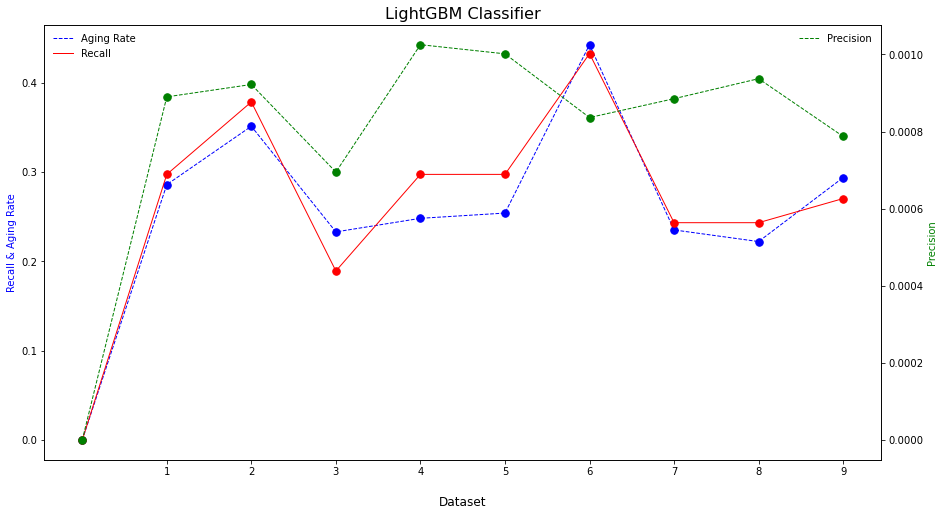

In [11]:
table_setC = runall_LightGBMC(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'LightGBM Classifier')

In [12]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,479.923077,230843.0,481.0,0.0,3.0,37.0,43203.0,0.000000,0.000000,0.000069,0.000000,0.000000
dataset 1,1.000000,4774.0,4774.0,11.0,12350.0,26.0,30856.0,0.000890,0.297297,0.285850,1.040047,0.211965
dataset 2,1.000000,6276.0,6276.0,14.0,15171.0,23.0,28035.0,0.000922,0.378378,0.351155,1.077525,0.276662
dataset 3,1.000000,5278.0,5278.0,7.0,10066.0,30.0,33140.0,0.000695,0.189189,0.232939,0.812182,0.000000
dataset 4,1.000000,4809.0,4809.0,11.0,10719.0,26.0,32487.0,0.001025,0.297297,0.248133,1.198139,0.234155
dataset 5,1.002501,4810.0,4798.0,11.0,10973.0,26.0,32233.0,0.001001,0.297297,0.254006,1.170432,0.230383
dataset 6,0.758675,4810.0,6340.0,16.0,19117.0,21.0,24089.0,0.000836,0.432432,0.442453,0.977352,0.000000
dataset 7,1.000000,4810.0,4810.0,9.0,10159.0,28.0,33047.0,0.000885,0.243243,0.235136,1.034478,0.172761
dataset 8,1.000000,4810.0,4810.0,9.0,9596.0,28.0,33610.0,0.000937,0.243243,0.222117,1.095114,0.179905
dataset 9,10.000000,4810.0,481.0,10.0,12693.0,27.0,30513.0,0.000787,0.270270,0.293759,0.920042,0.000000


### Regressor

In [ ]:
pr_dict, table_setR = runall_LightGBMR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                       thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'LightGBM Regressor')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### export

In [13]:
savedate = '20211123'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'LightGBM'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'LightGBM')